<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from typing_extensions import Literal
from IPython.display import clear_output

In [2]:
# узнать, какой GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar  3 17:31:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.30       Driver Version: 522.30       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   58C    P0    14W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [3]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


Length     Width    Size    Conc   Conc1      Asym   M3Long  M3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110  -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238  -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580 -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633  -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525  21.8393   

     Alpha      Dist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [258]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [259]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [260]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [5]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

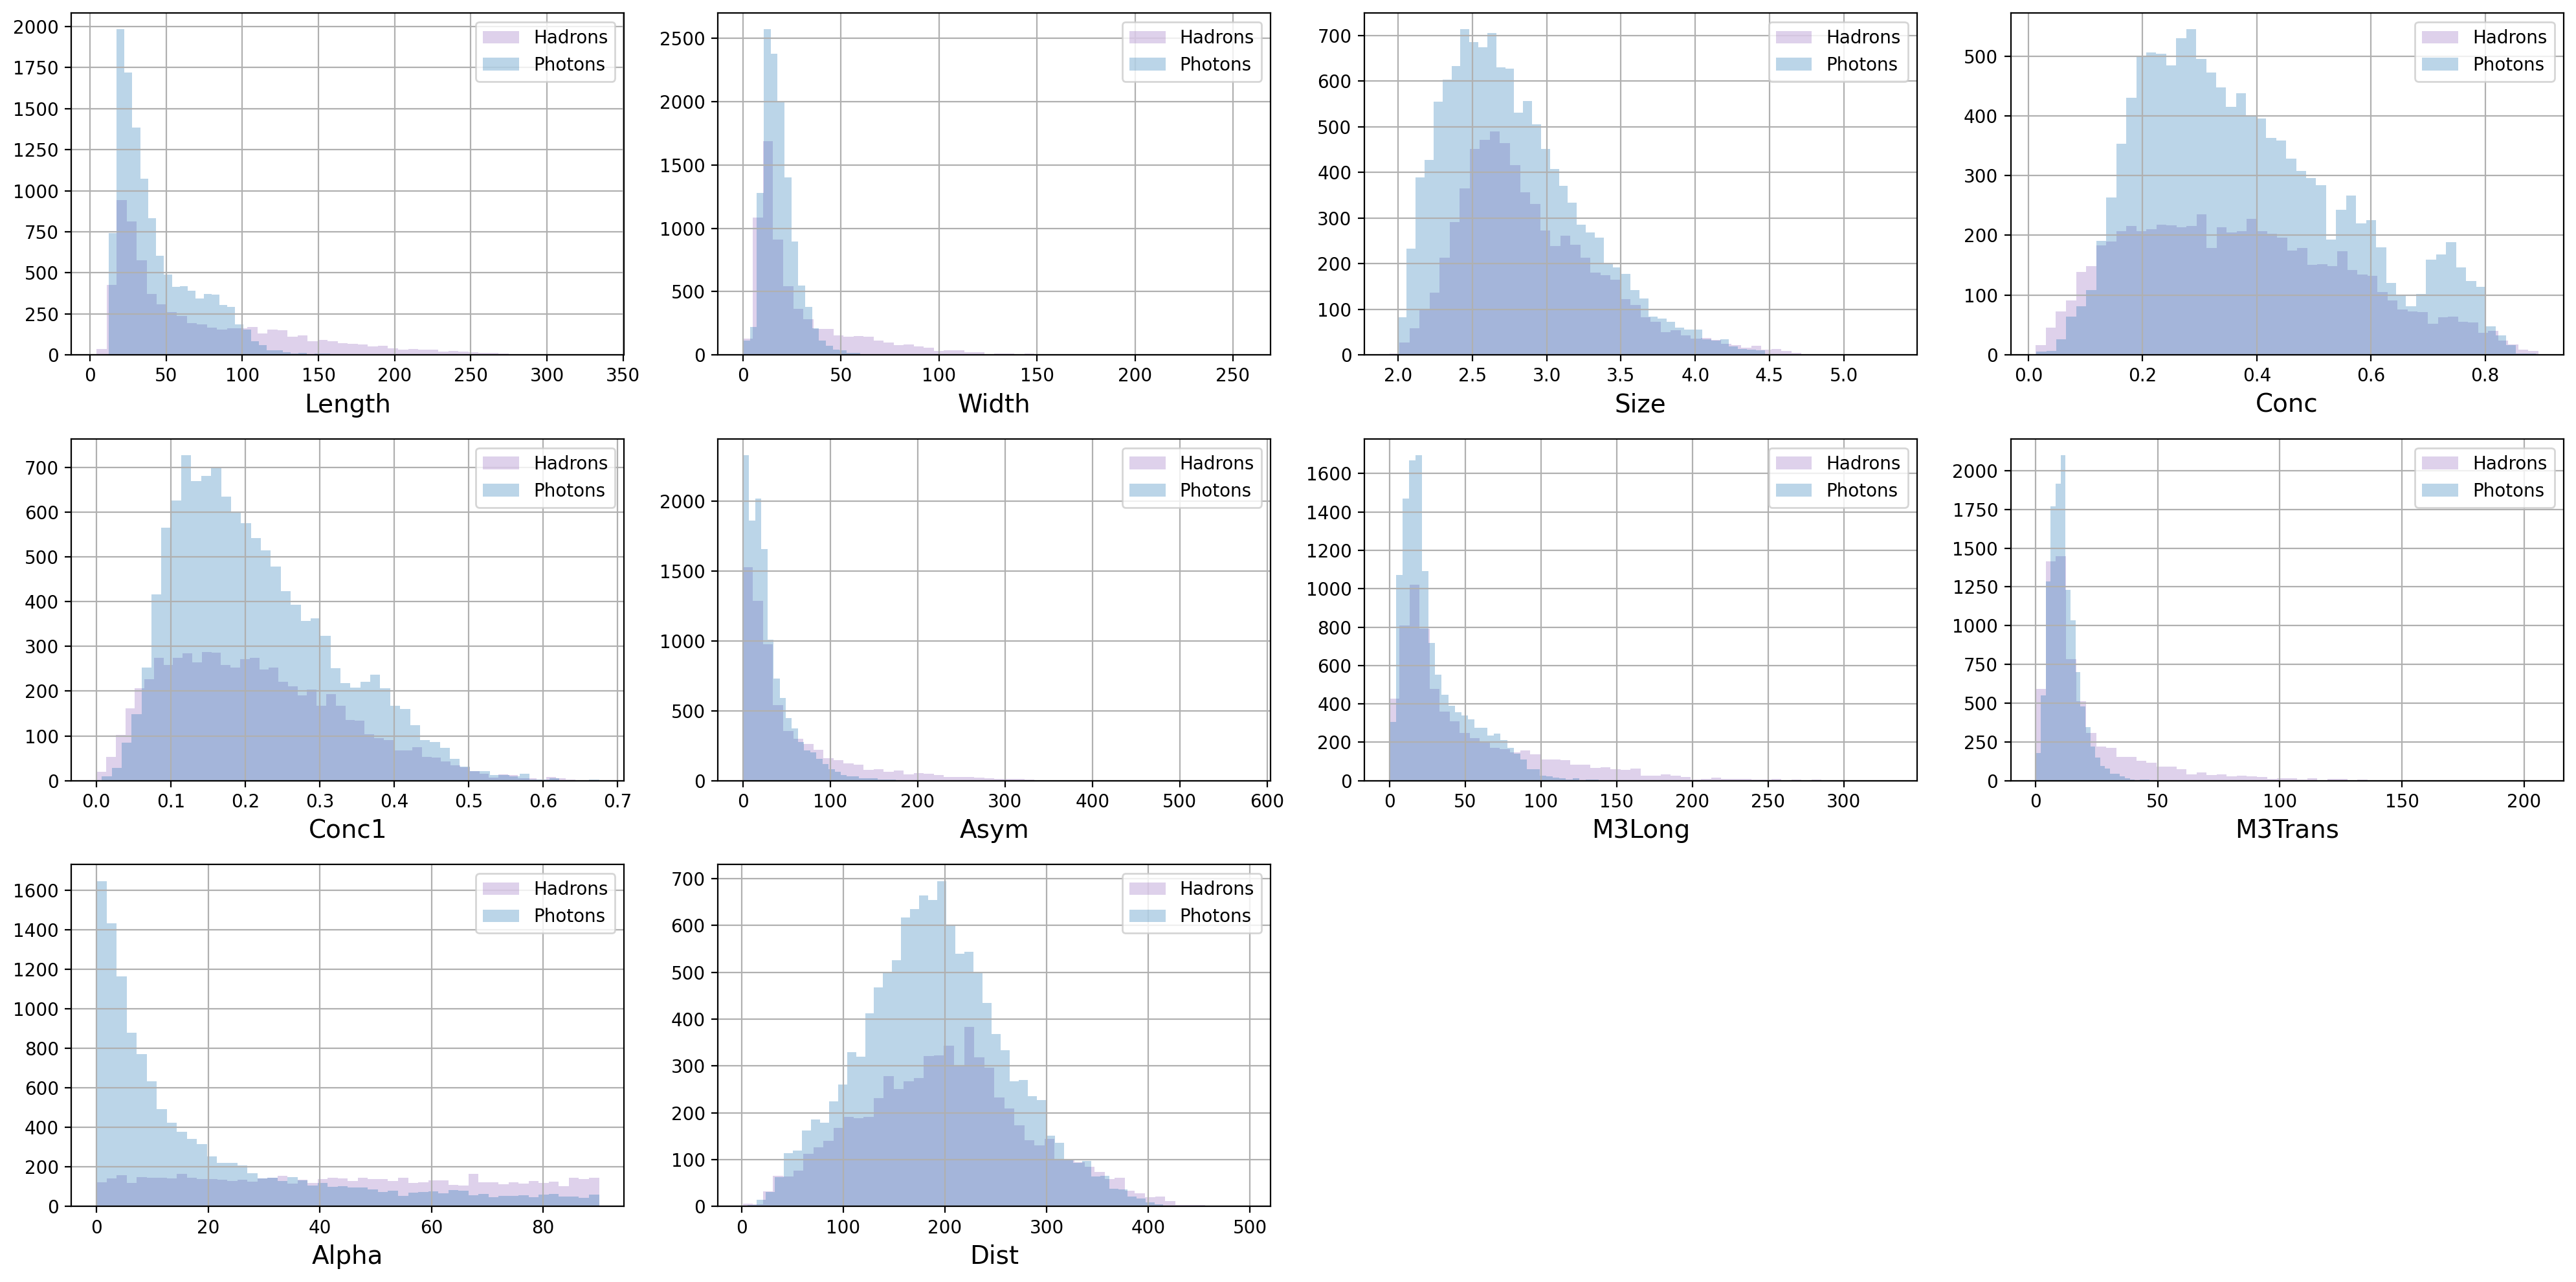

In [10]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [6]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

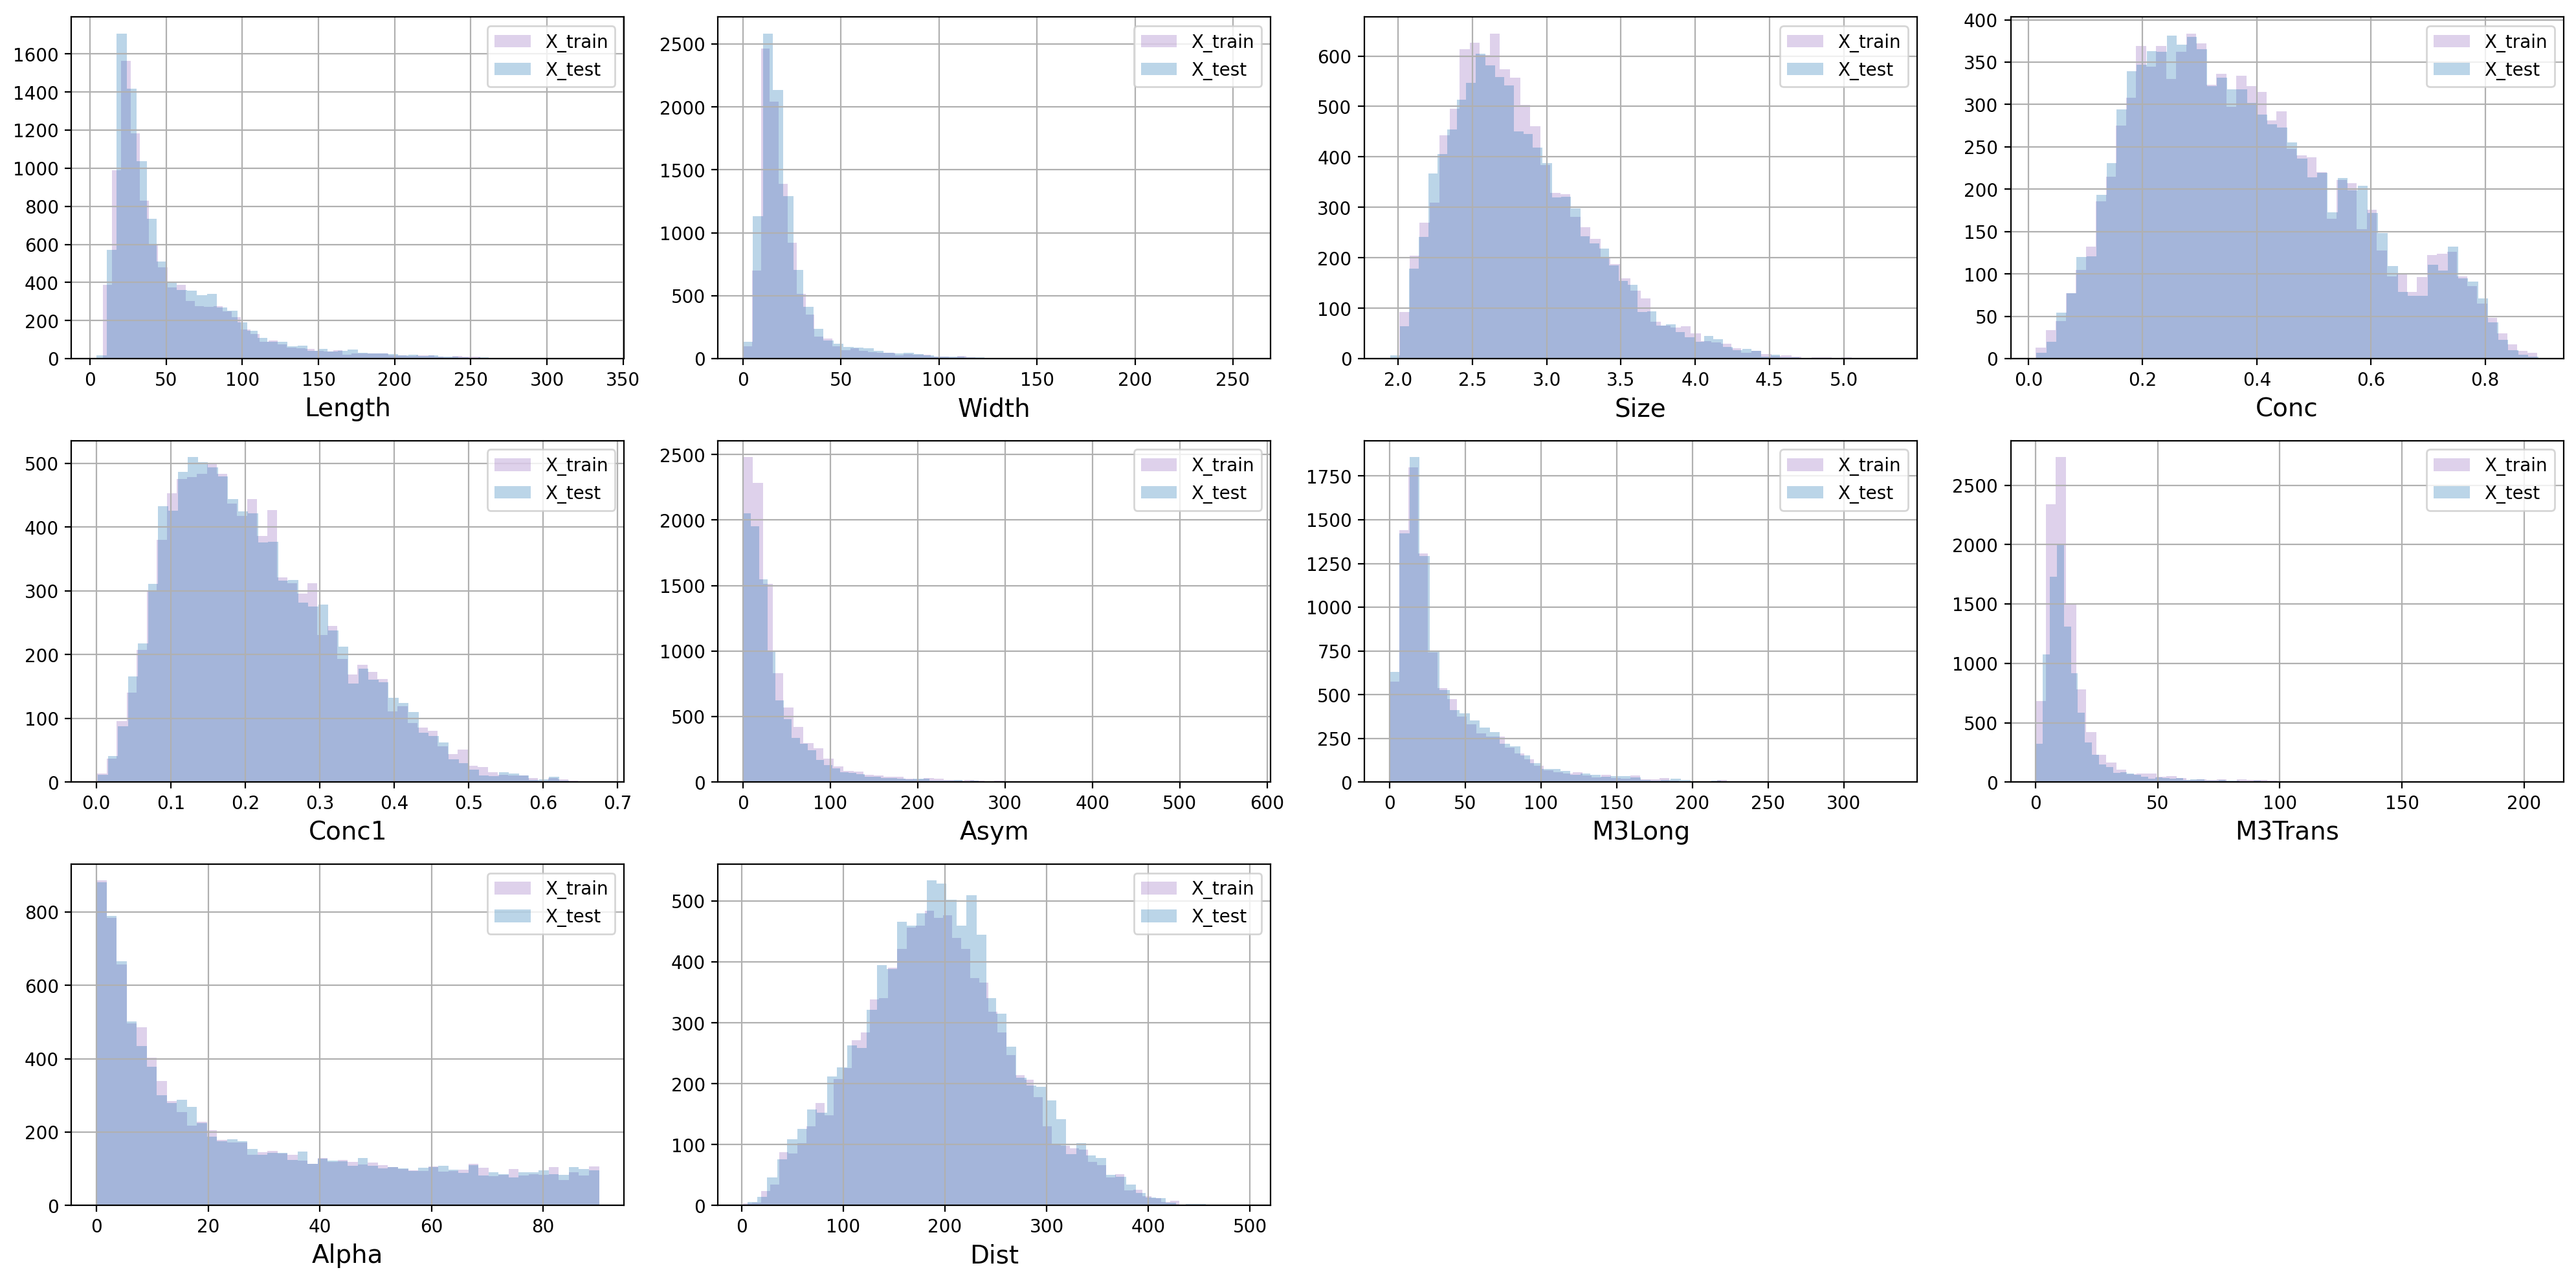

In [14]:
plot_hists(
    X_train, X_test, names, label1="Train", label2="Test", bins=50
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [7]:
from sklearn.preprocessing import QuantileTransformer

QuantTrans = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=13).fit(X_train)

X_train = QuantTrans.transform(X_train)
X_test = QuantTrans.transform(X_test)

Я немного поэксперементировал с параметром `n_quantiles` у скейлера и понял, что значение 1000 является оптимальным — тогда распределение получается не "дерганным".

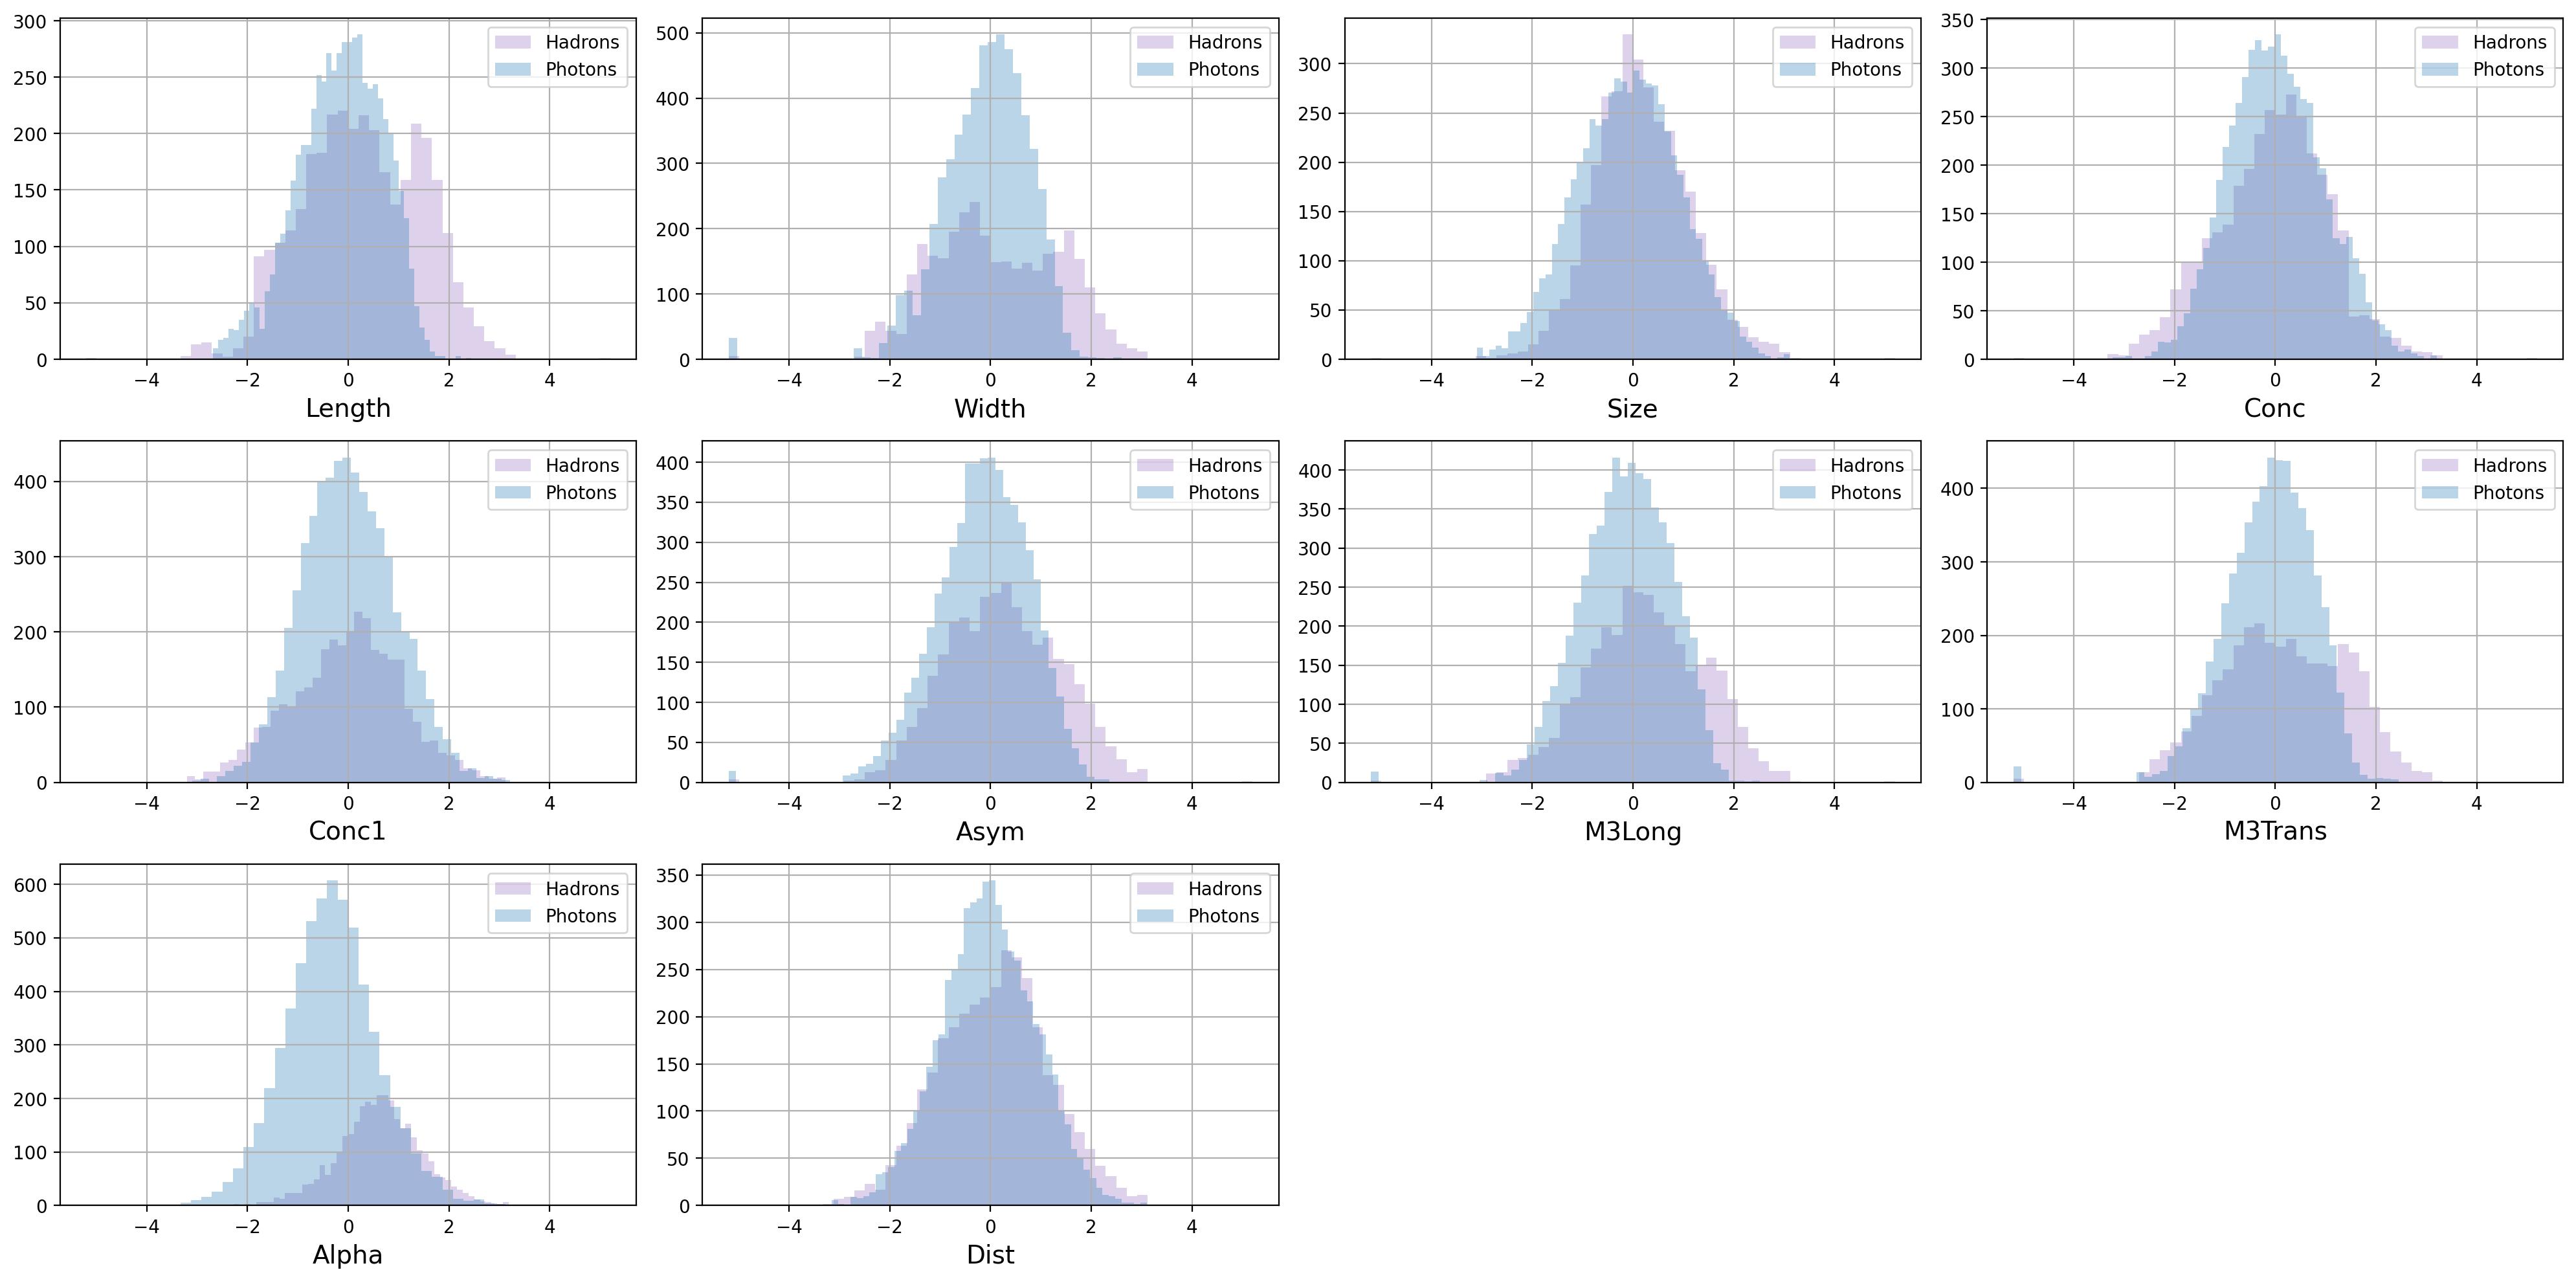

In [250]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

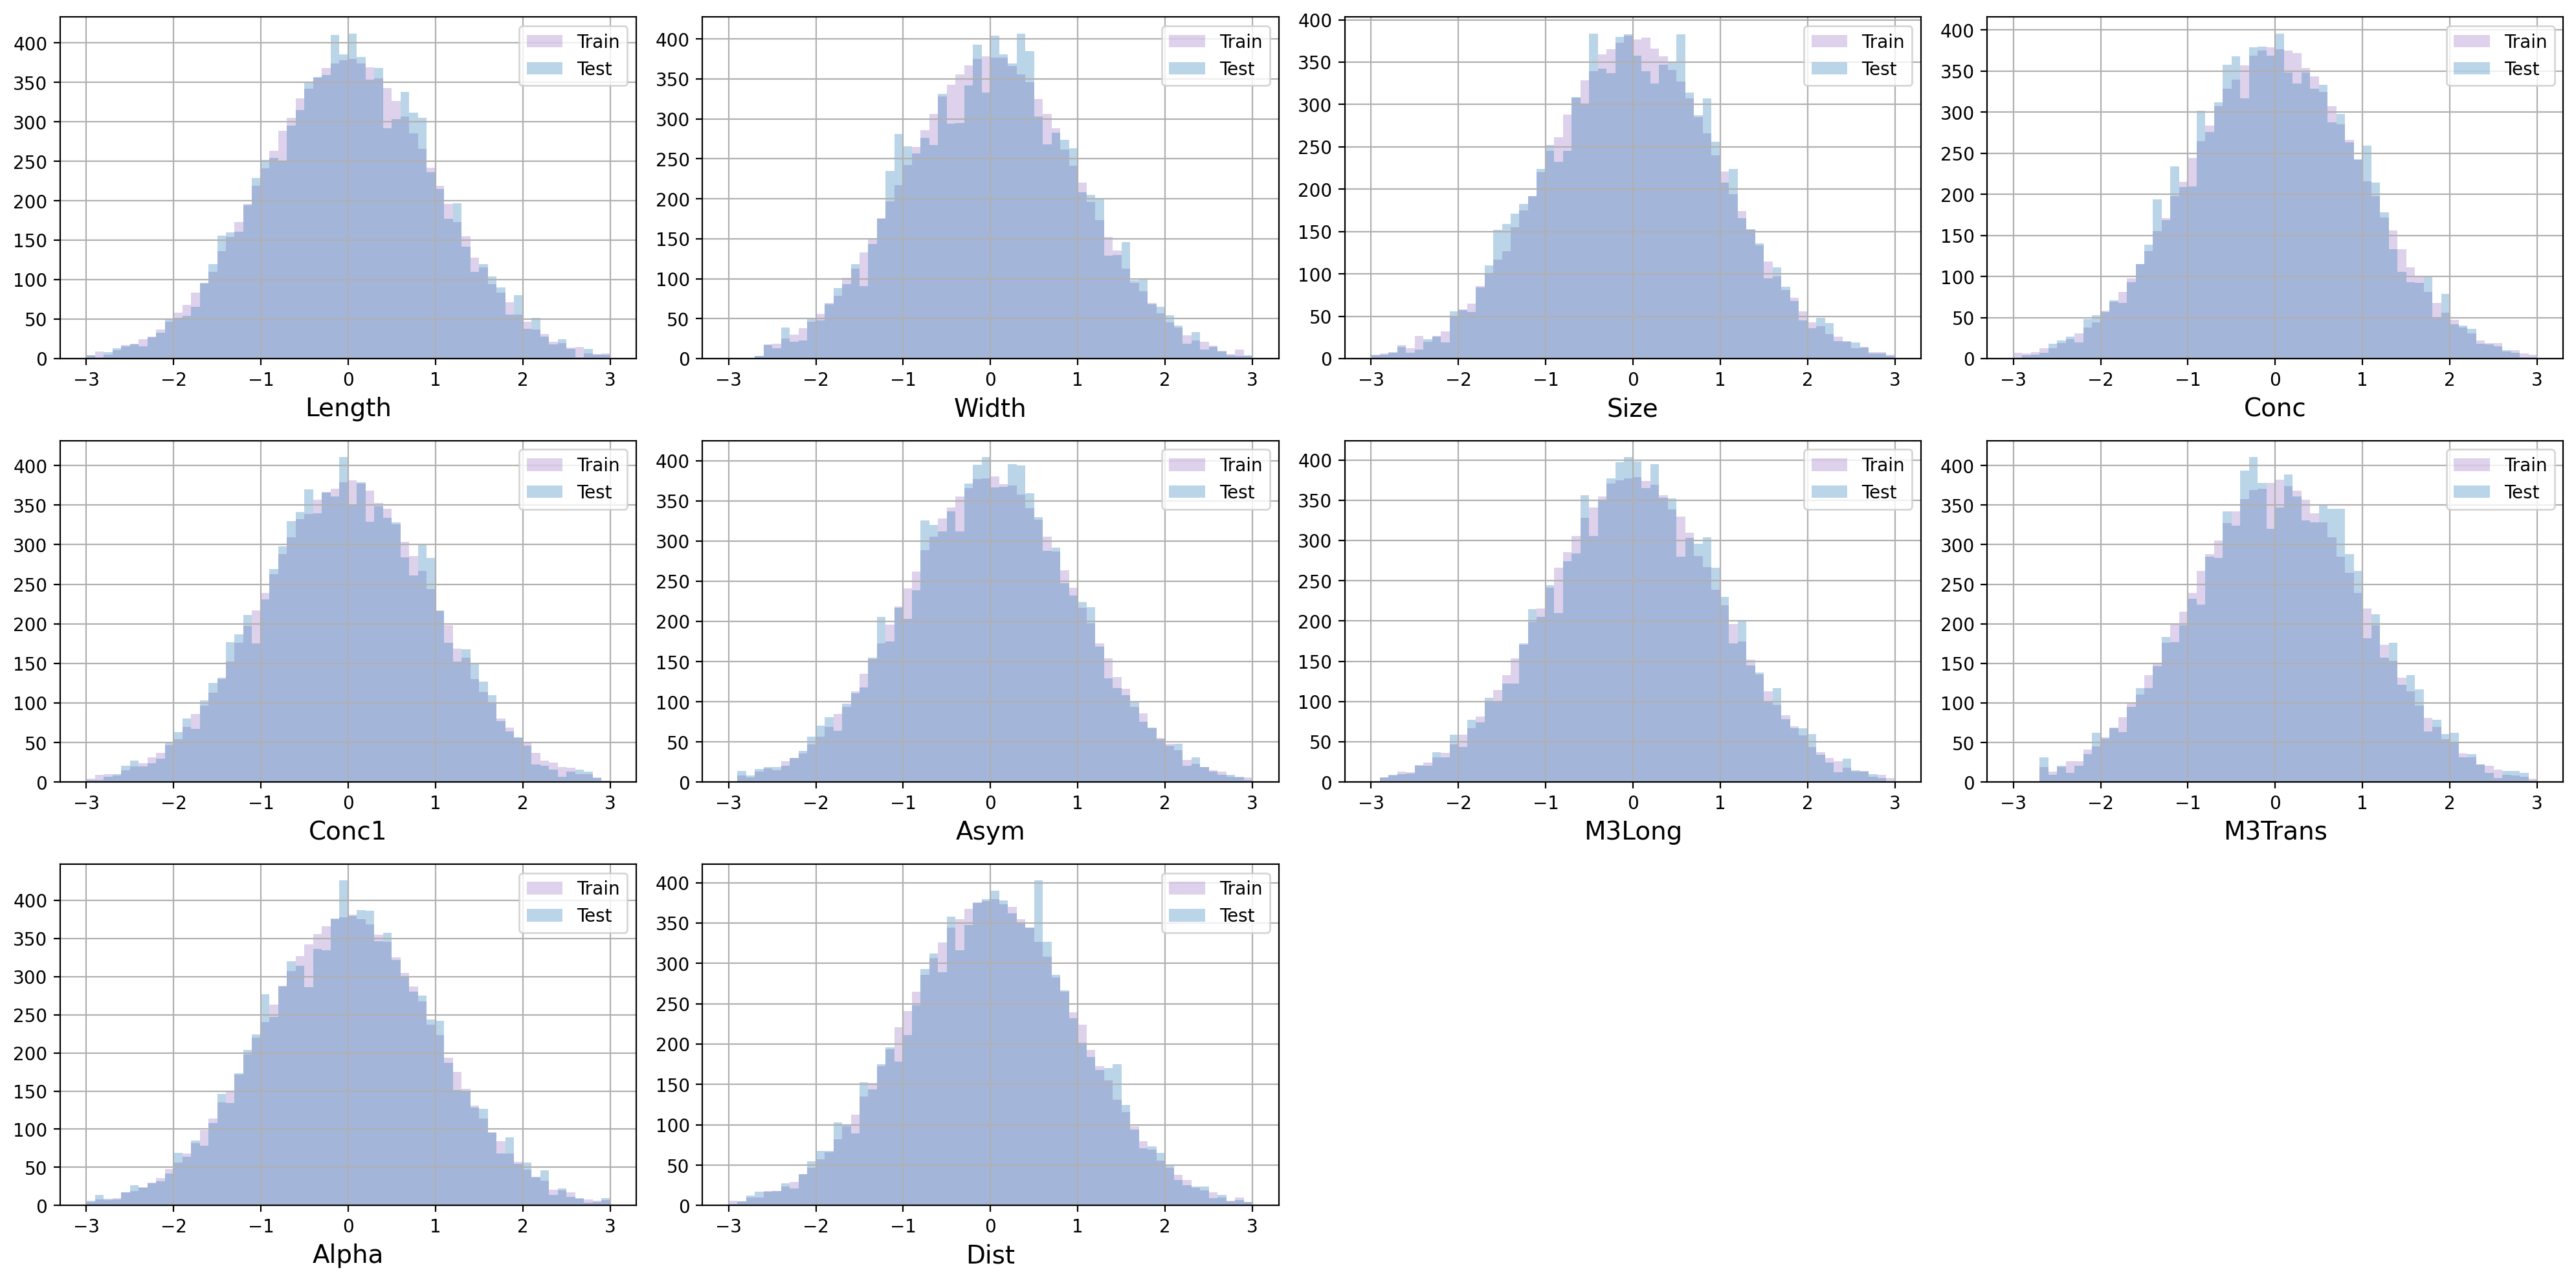

In [264]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

Выглядит прекрасно!

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
DEVICE

device(type='cuda')

Воспользую функцией из ДЗ№2 по курсу ОГО в прошлом семестре для фиксирования случайности:

In [10]:
import random
import os

def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [11]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [12]:
def generate(generator, y, latent_dim):
    prior = torch.distributions.Normal(
        torch.zeros(latent_dim).to(DEVICE), torch.ones(latent_dim).to(DEVICE)
    )

    num_objects = y.shape[0]
    generator.to(DEVICE)
    
    z = prior.sample((num_objects,)).to(DEVICE)
    X_fake = generator(z, y)
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

**Ответ**: возможно, переводящая выходы модели в интервал [0, 1] — сигмоида, например, однако нам не обязательно использовать ее, т.к. у нас не стоит задача определения вероятностей. Используемая функция потерь будет стимулировать модель выдавать логиты, которые при желании можно легко перевести в интервал [0, 1]; однако наша задача, прежде всего, построить корректный классификатор. Поэтому сами вероятности (то, что будет происходить под капотом) нас не интересуют. К тому же, мы решаем задачу бинарной классификации, а не мультиклассовой => применять софтмакс не нужно, модели будет несложно справиться и так.

In [13]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.n_inputs = n_inputs

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

**Ответ**: 0.5, т.к. у нас два класса, и это соответствует случайному угадыванию, т.е. дискриминатор не может отличить fake от real. Это будет означать, что генератор хорошо создает искуственные данные.

In [14]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    # конкатинирую признаки и класс
    X_real = torch.cat((X_real, y_real), dim=1)
    X_fake = torch.cat((X_fake, y_fake), dim=1)
    # создаю новые метки для дискриминатора: real или fake
    y_real = torch.ones(X_real.shape[0])
    y_fake = torch.zeros(X_fake.shape[0])

    # делаю сплит по отдельности (для учета баланса классов)
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_real, y_real, stratify=y_real, test_size=0.25, shuffle=True, random_state=13
    )
    X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(
    X_fake, y_fake, stratify=y_fake, test_size=0.25, shuffle=True, random_state=13
    )

    # объединяю сплиты с учетом баланса классов
    X_train = torch.cat((X_real_train, X_fake_train), dim=0).detach().cpu().numpy()
    X_test = torch.cat((X_real_test, X_fake_test), dim=0).detach().cpu().numpy()
    y_train = torch.cat((y_real_train, y_fake_train), dim=0).numpy()
    y_test = torch.cat((y_real_test, y_fake_test), dim=0).numpy()

    # обучаю модели
    lr = LogisticRegression(n_jobs=-1)
    gb = GradientBoostingClassifier()

    lr.fit(X_train, y_train)
    gb.fit(X_train, y_train)

    # делаю предикты и считаю скор
    y_pred_lr = lr.predict(X_test)
    y_pred_gb = gb.predict(X_test)

    lin_reg_score = accuracy_score(y_test, y_pred_lr)
    boosting_score = accuracy_score(y_test, y_pred_gb)
    print('Linear regression score: ' + str(lin_reg_score))
    print('Boosting score: ' + str(boosting_score))

    return lin_reg_score, boosting_score

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [15]:
# функция для подсчета лосса, источник: первый семинар

def gan_loss(
    discriminator,
    X_real,
    X_fake,
    y_cond,
    by: Literal["generator", "discriminator"] = "generator",
) -> torch.Tensor:
    '''
    Для применения нужно выбрать, для какой из моделей нужно считать лосс
    '''
    if by == "generator":
        return torch.mean(discriminator(X_fake, y_cond))
    elif by == "discriminator":
        return (
            torch.mean(discriminator(X_real, y_cond)) - torch.mean(discriminator(X_fake, y_cond))
        )

In [16]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        # контейнеры для лосса
        self.gen_loss_trace = []
        self.discr_loss_trace = []
        self.lin_reg_score_trace = []
        self.boosting_score_trace = []

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):
        iter_i = 0

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                # переносим реальные объекты на устройство
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                # генерируем новые объекты
                X_fake = generate(self.generator, cond_batch, self.latent_dim).to(DEVICE)

                # обновляем шаг генератора или дискриминатора в зависимости от номера итерации
                if (i % (1 + self.n_critic)) < 1:
                    # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    gen_loss = gan_loss(
                        self.discriminator, real_batch, X_fake, cond_batch, "generator"
                    )
                    gen_loss.backward()
                    self.opt_gen.step()
                    # логируем лосс генератора
                    self.gen_loss_trace.append((iter_i, gen_loss.item()))
                else:
                    # делаем шаг обучения дискриминатора
                    self.opt_disc.zero_grad()
                    discr_loss = gan_loss(
                        self.discriminator, real_batch, X_fake, cond_batch, "discriminator"
                    )
                    discr_loss.backward()  # retain_graph=True, create_graph=True
                    self.opt_disc.step()
                    # логируем лосс дискриминатора
                    self.discr_loss_trace.append((iter_i, discr_loss.item()))

                    # ограничиваем параметры
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                iter_i += 1

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)  # я перевел шум на устройство для эффективности
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создаем выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запускаем работу фукнции other_agent_score
            
            ## создаем выборку
            idx = torch.randint(0, X_real.shape[0], (1000,))
            X_real_sub = X_real[idx]  # это X_train
            y_cond_sub = y_cond[idx]  # это y_train

            X_fake = generate(self.generator, y_cond_sub, self.latent_dim)

            ## запускаем фунцкию other_agent_score()
            lin_reg_score, boosting_score = other_agent_score(X_real_sub, y_cond_sub, X_fake, y_cond_sub)
            self.lin_reg_score_trace.append((epoch, lin_reg_score))
            self.boosting_score_trace.append((epoch, boosting_score))

            ## визуализация результатов эпохи
            clear_output(wait=True)
            plt.figure(figsize=(17, 5))
            
            # лосс генератора
            plt.subplot(1, 3, 1)
            plt.xlabel("Iteration")
            plt.ylabel("Generator loss")
            plt.plot([p[0] for p in self.gen_loss_trace], 
                     [p[1] for p in self.gen_loss_trace]
                     )

            # лосс дискриминатора
            plt.subplot(1, 3, 2)
            plt.xlabel("Iteration")
            plt.ylabel("Discriminator loss")
            plt.plot(
                [p[0] for p in self.discr_loss_trace],
                [p[1] for p in self.discr_loss_trace],
                color="orange")

            # лосс моделей
            plt.subplot(1, 3, 3)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.plot([p[0] for p in self.lin_reg_score_trace],
                     [p[1] for p in self.lin_reg_score_trace],
                     label='LogisticRegression score',
                     color='green')
            plt.plot([p[0] for p in self.boosting_score_trace],
                     [p[1] for p in self.boosting_score_trace],
                     label='GradientBoosting score',
                     color='red')
            plt.legend(loc="best")
            
            plt.show()
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

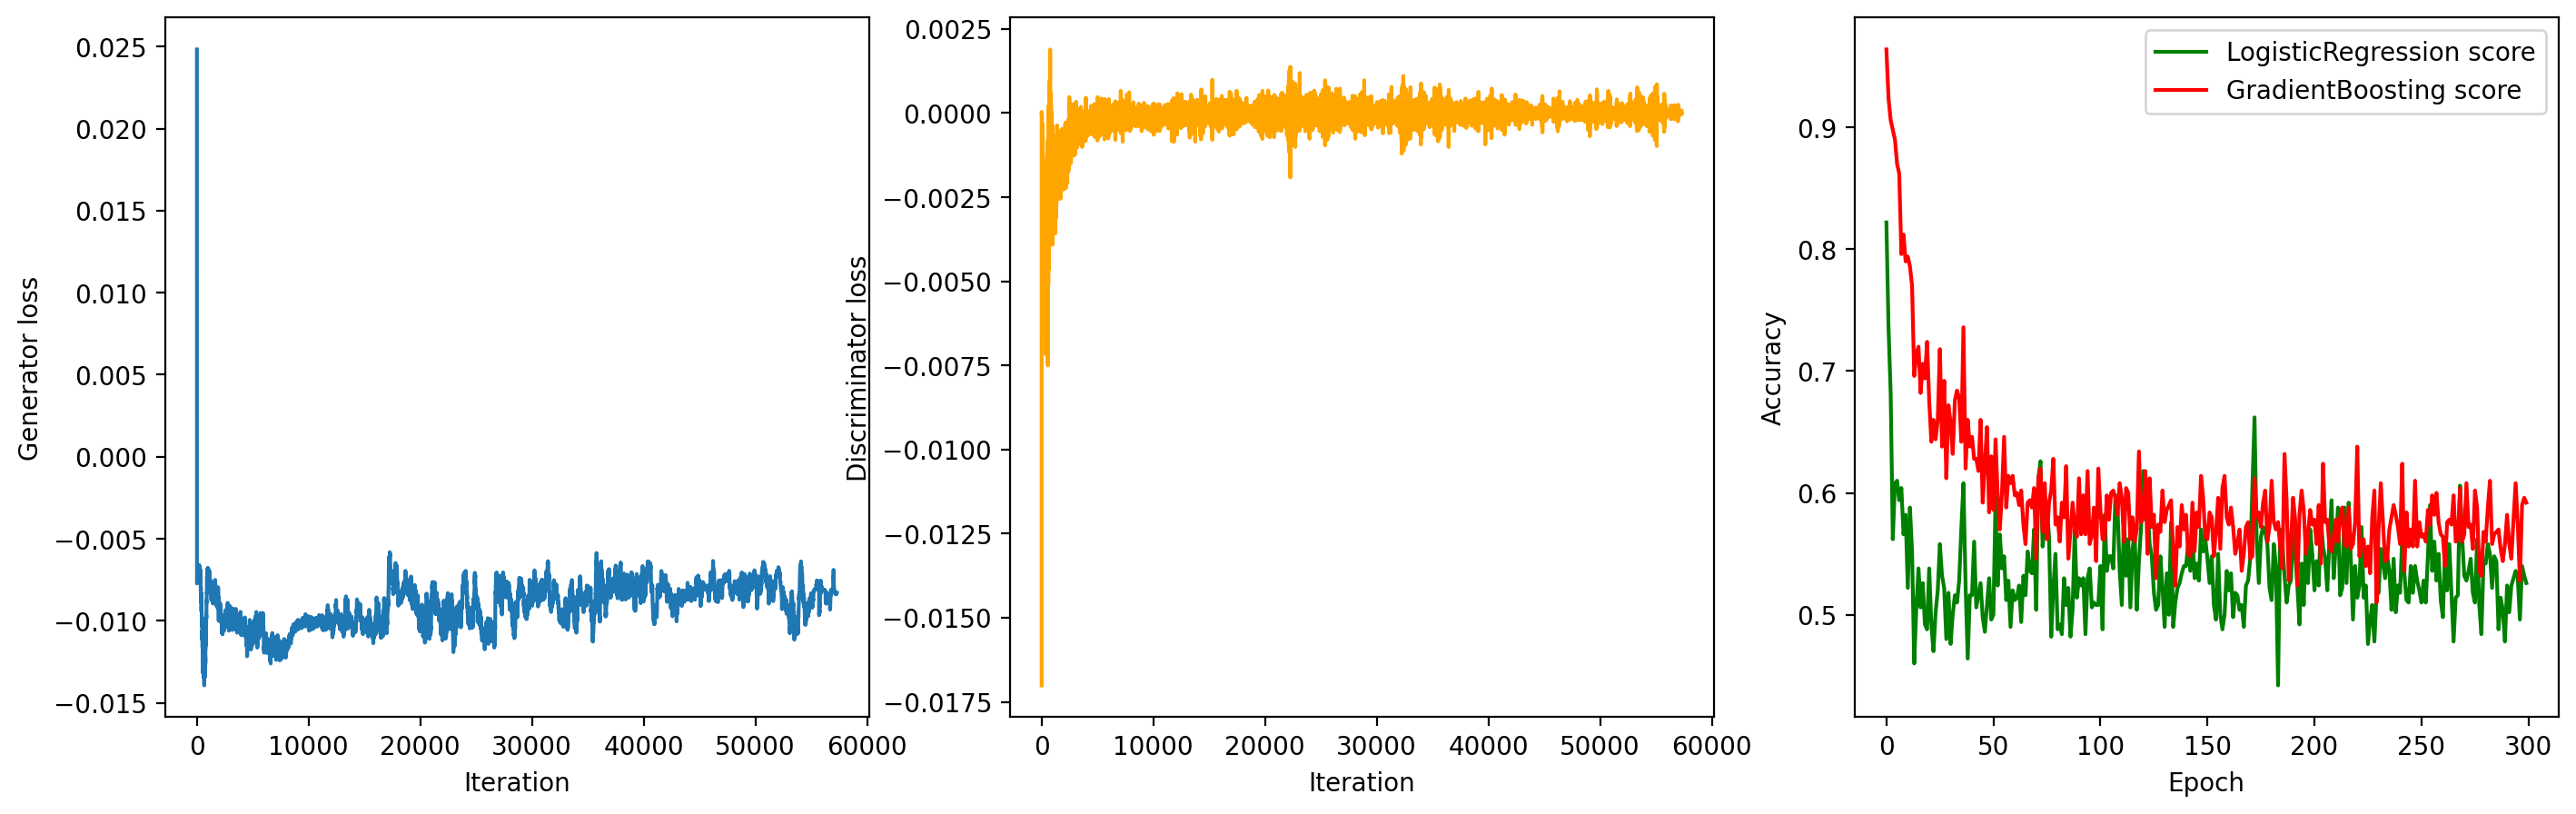

CPU times: total: 9min 59s
Wall time: 10min 23s


In [301]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=300,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

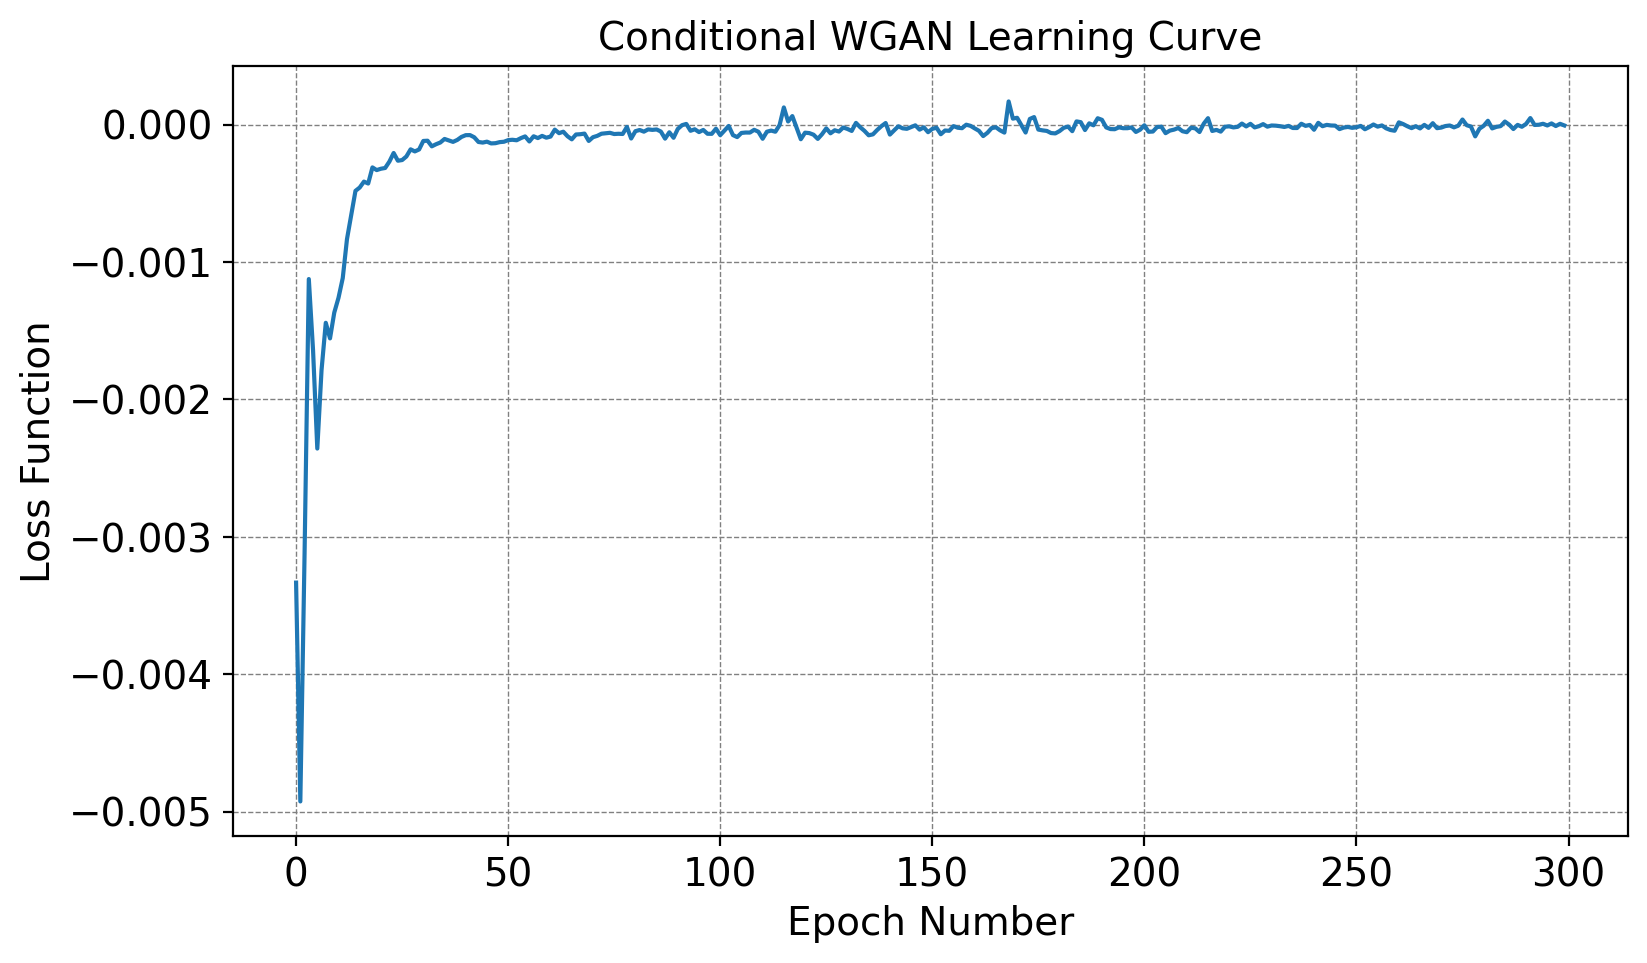

In [302]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

**Примечание**: для научного интереса я буду приводить *два варианта гистограмм*: с нормированными скейлером значениями (нормальные распределения) и с трансформированными в исходный вид значениями.

In [303]:
X_fake_train_norm = generate(fitter.generator, torch.tensor(y_train, dtype=torch.float, device=DEVICE), latent_dim).detach().cpu().numpy()
X_fake_train = QuantTrans.inverse_transform(X_fake_train_norm)

X_train_norm = X_train.copy()
X_train = QuantTrans.inverse_transform(X_train_norm)

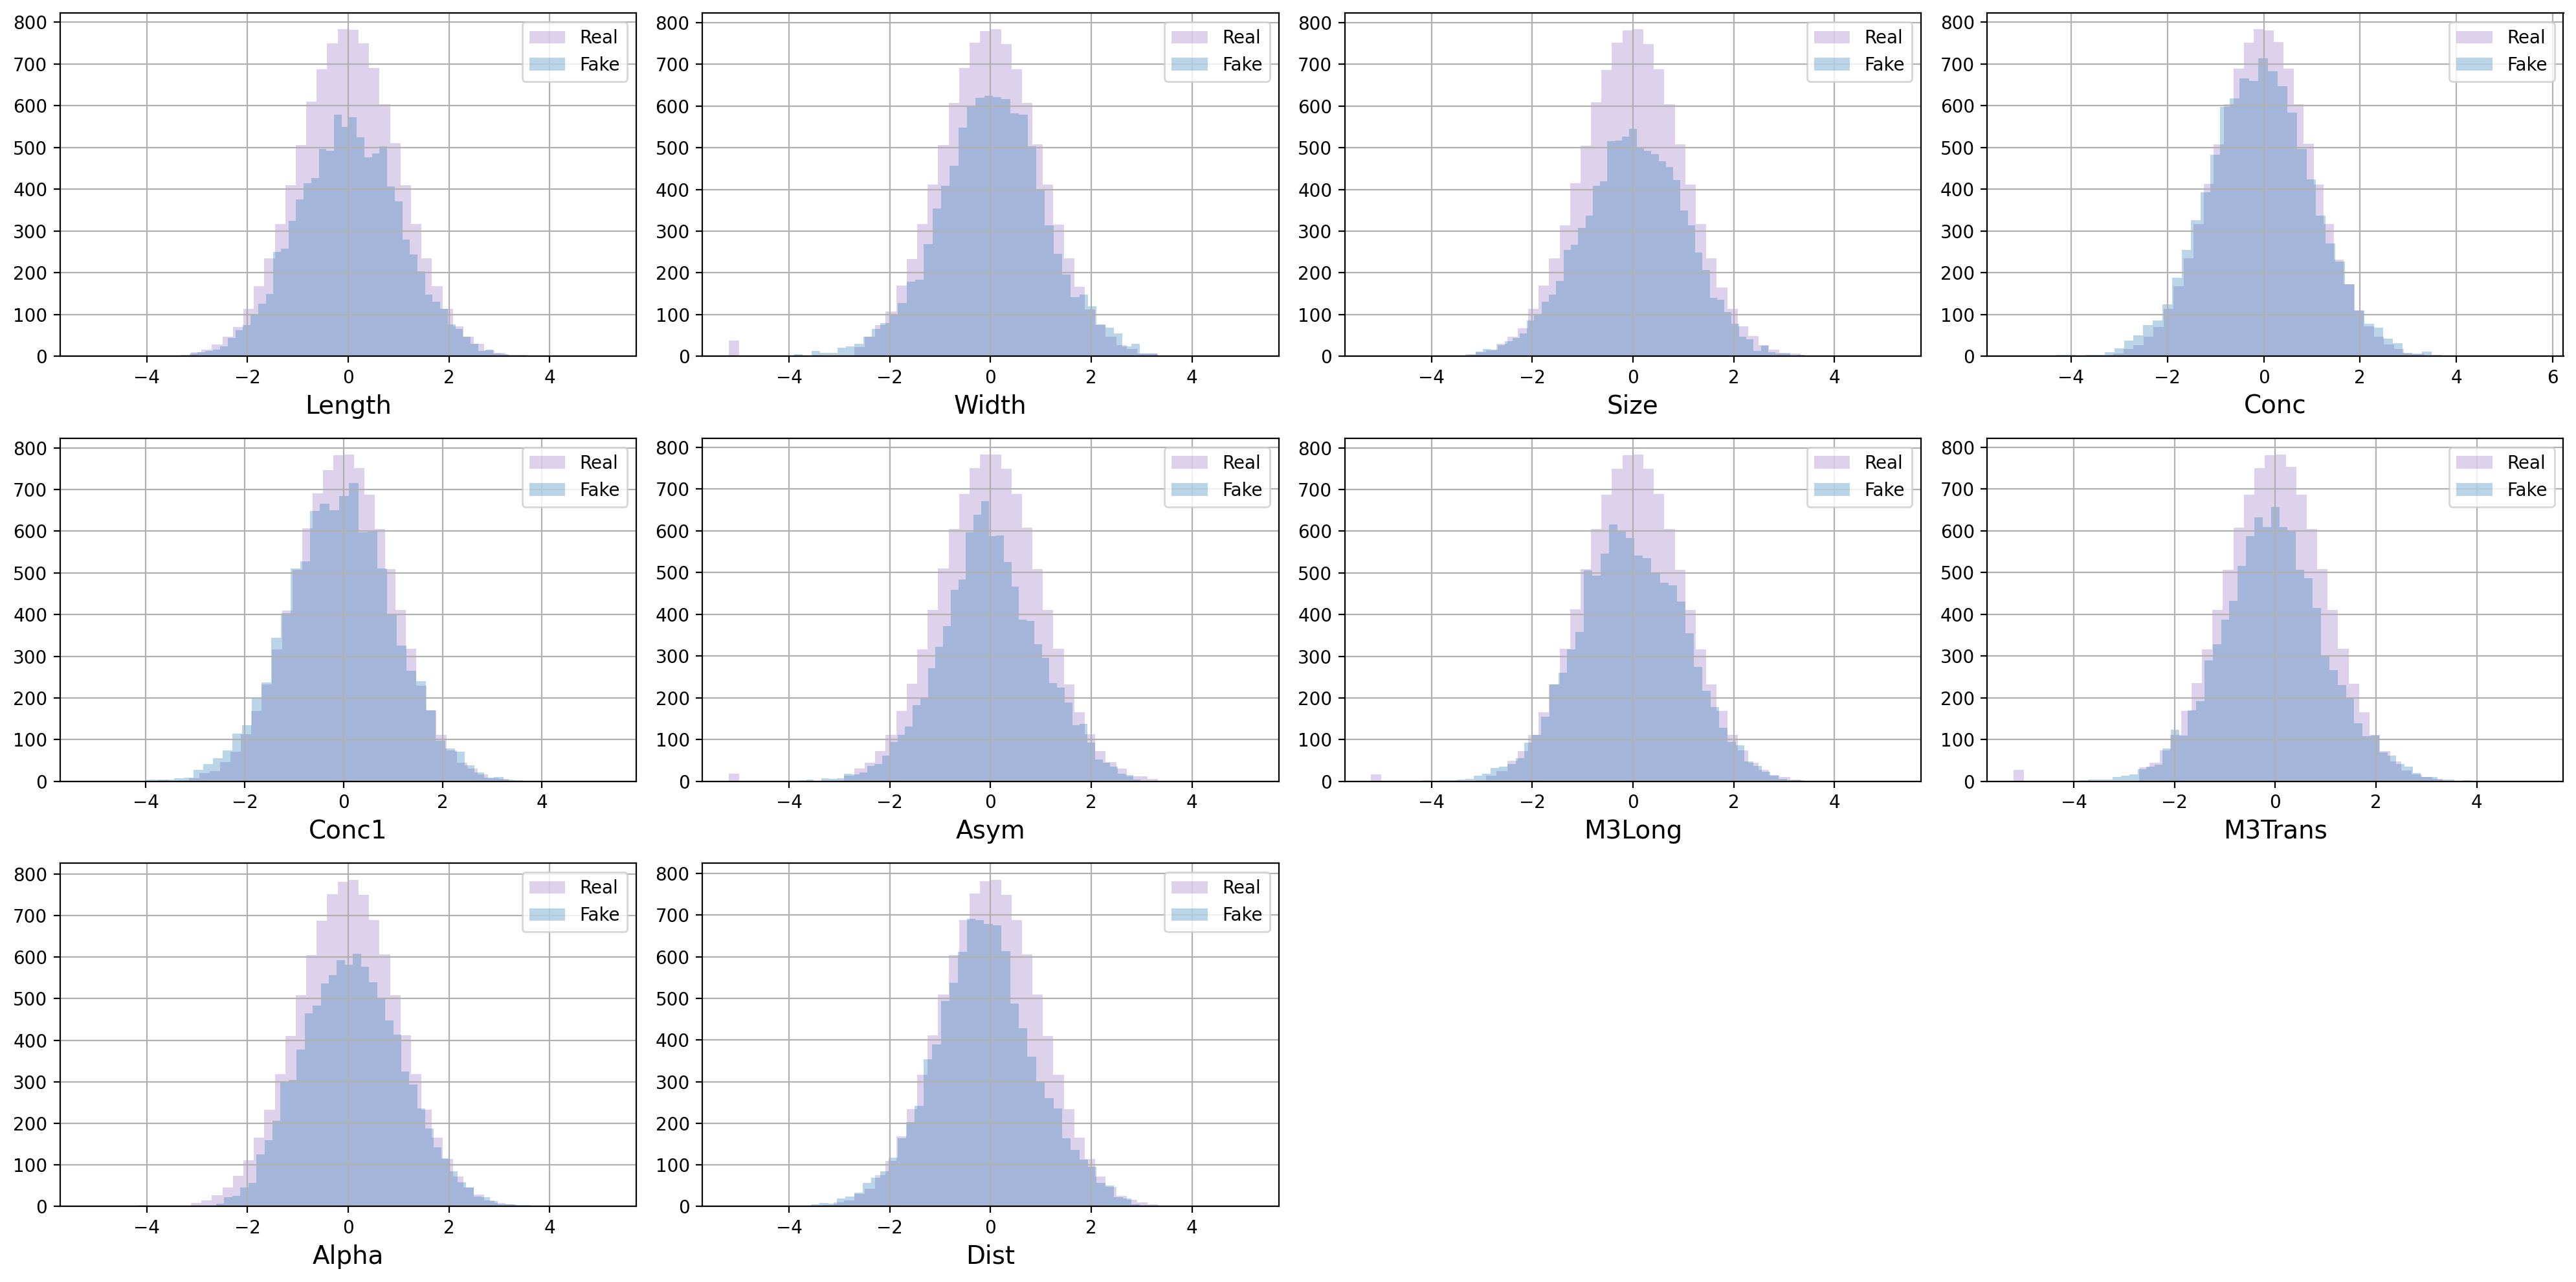

In [311]:
plot_hists(X_train_norm, X_fake_train_norm, names, label1="Real", label2="Fake", bins=50)

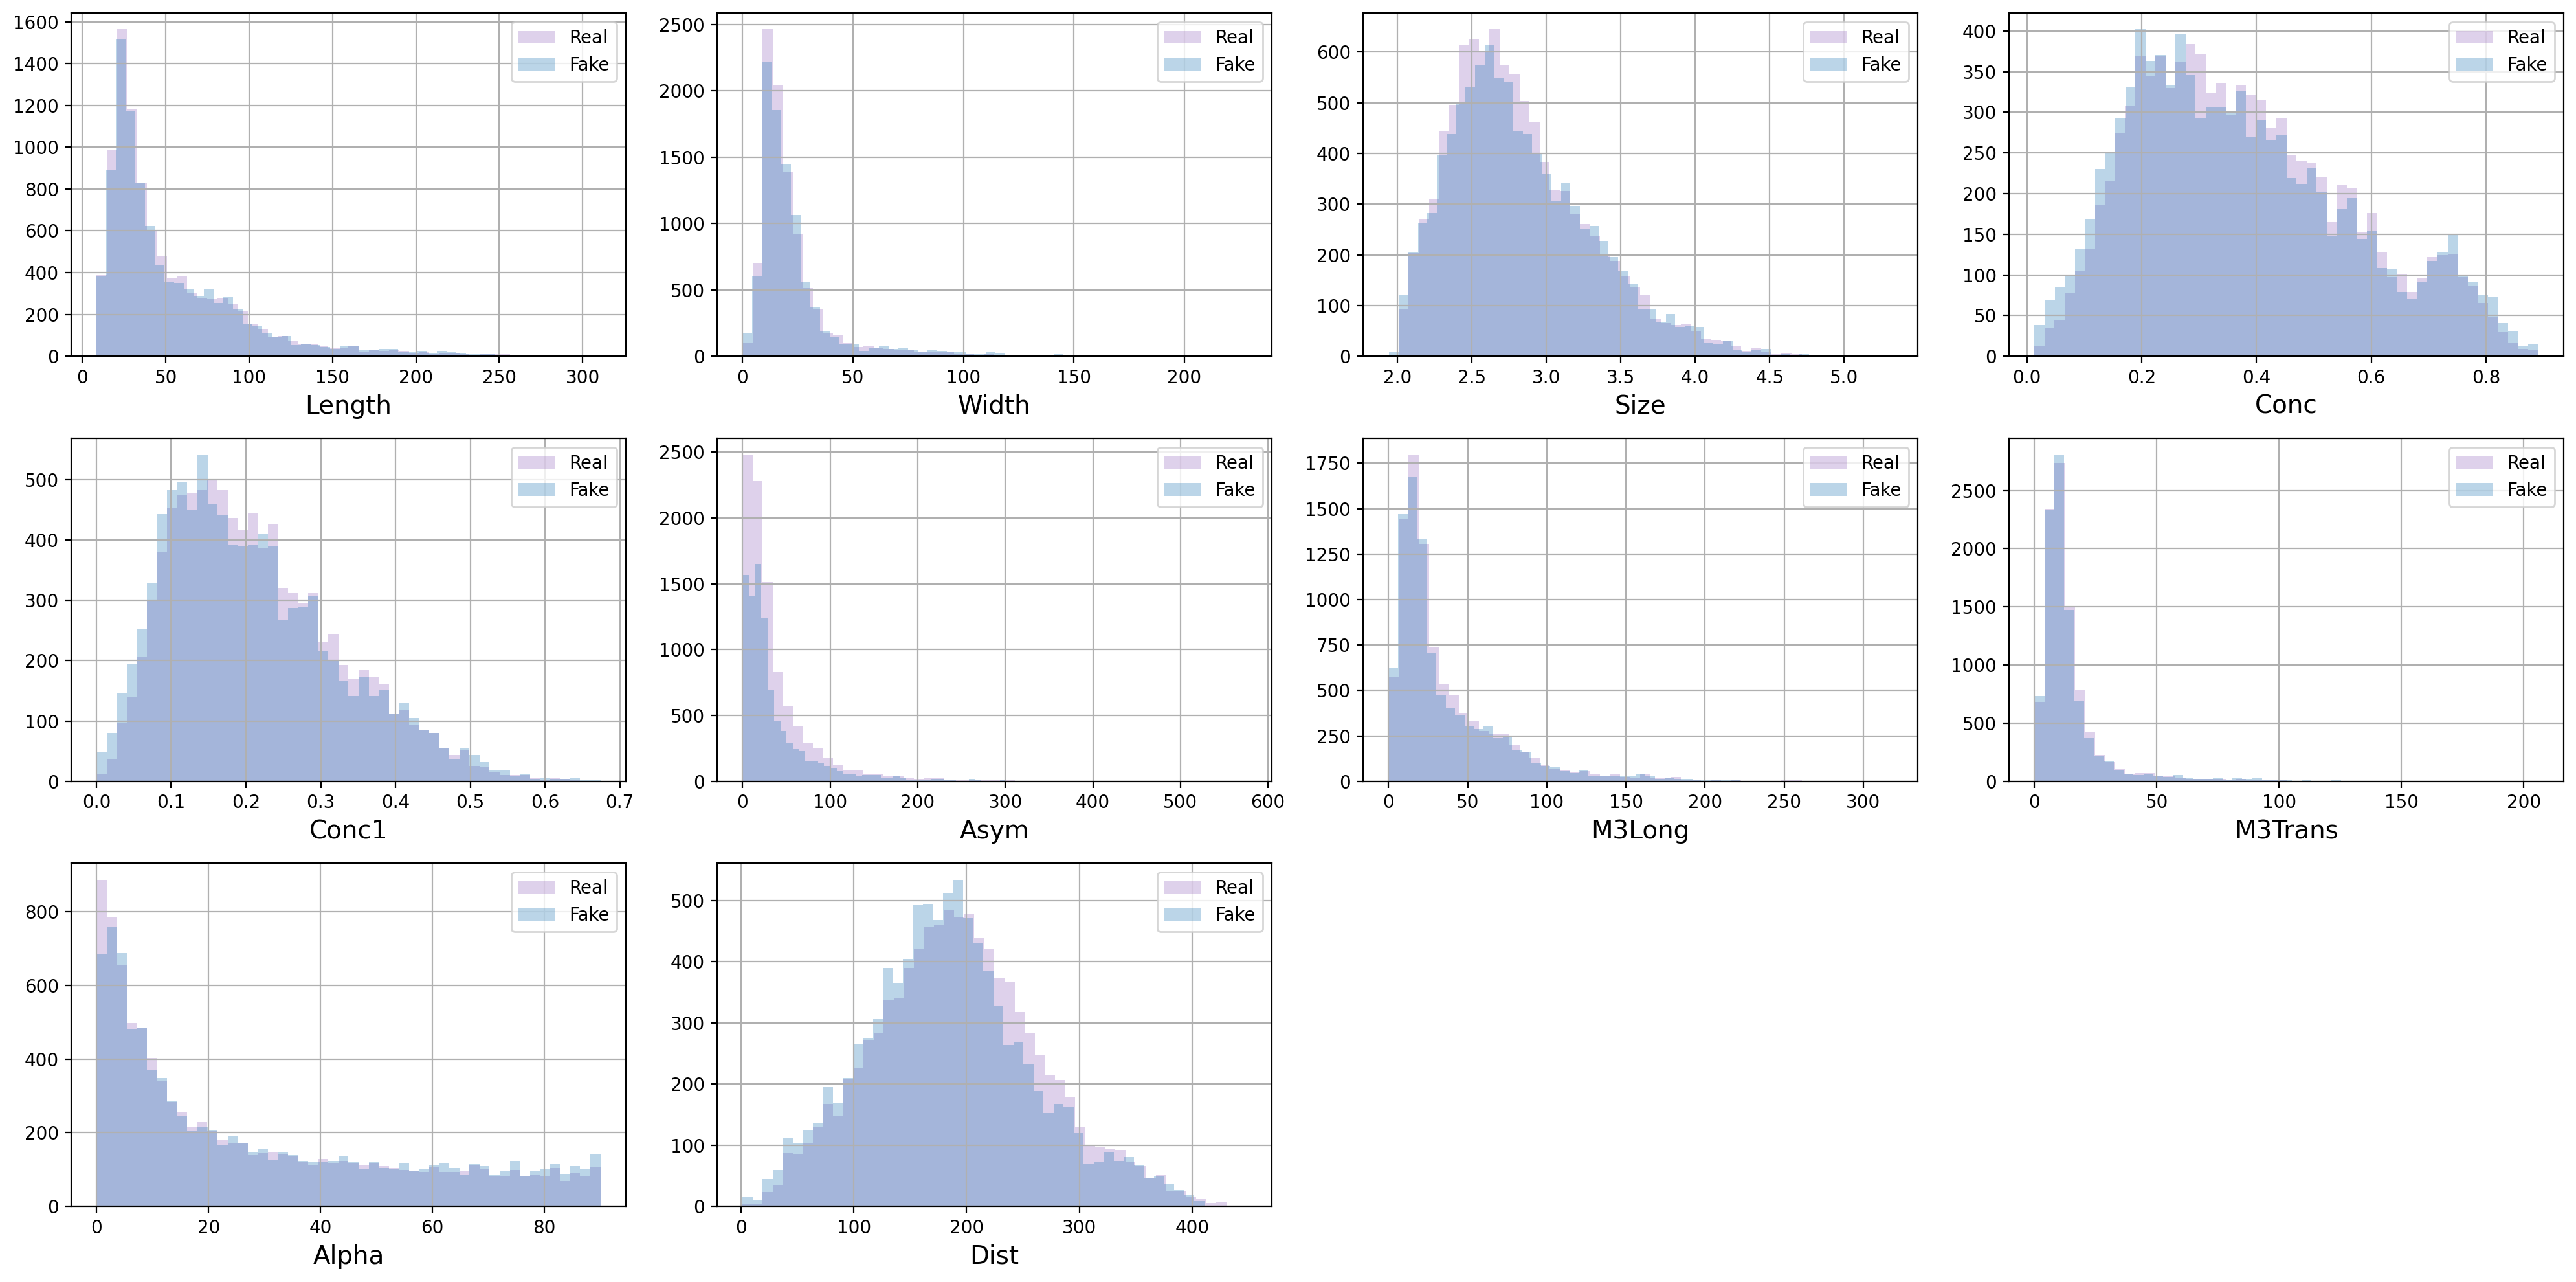

In [312]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [305]:
X_fake_test_norm = generate(fitter.generator, torch.tensor(y_test, dtype=torch.float, device=DEVICE), latent_dim).detach().cpu().numpy()
X_fake_test = QuantTrans.inverse_transform(X_fake_test_norm)

X_test_norm = X_test.copy()
X_test = QuantTrans.inverse_transform(X_test_norm)

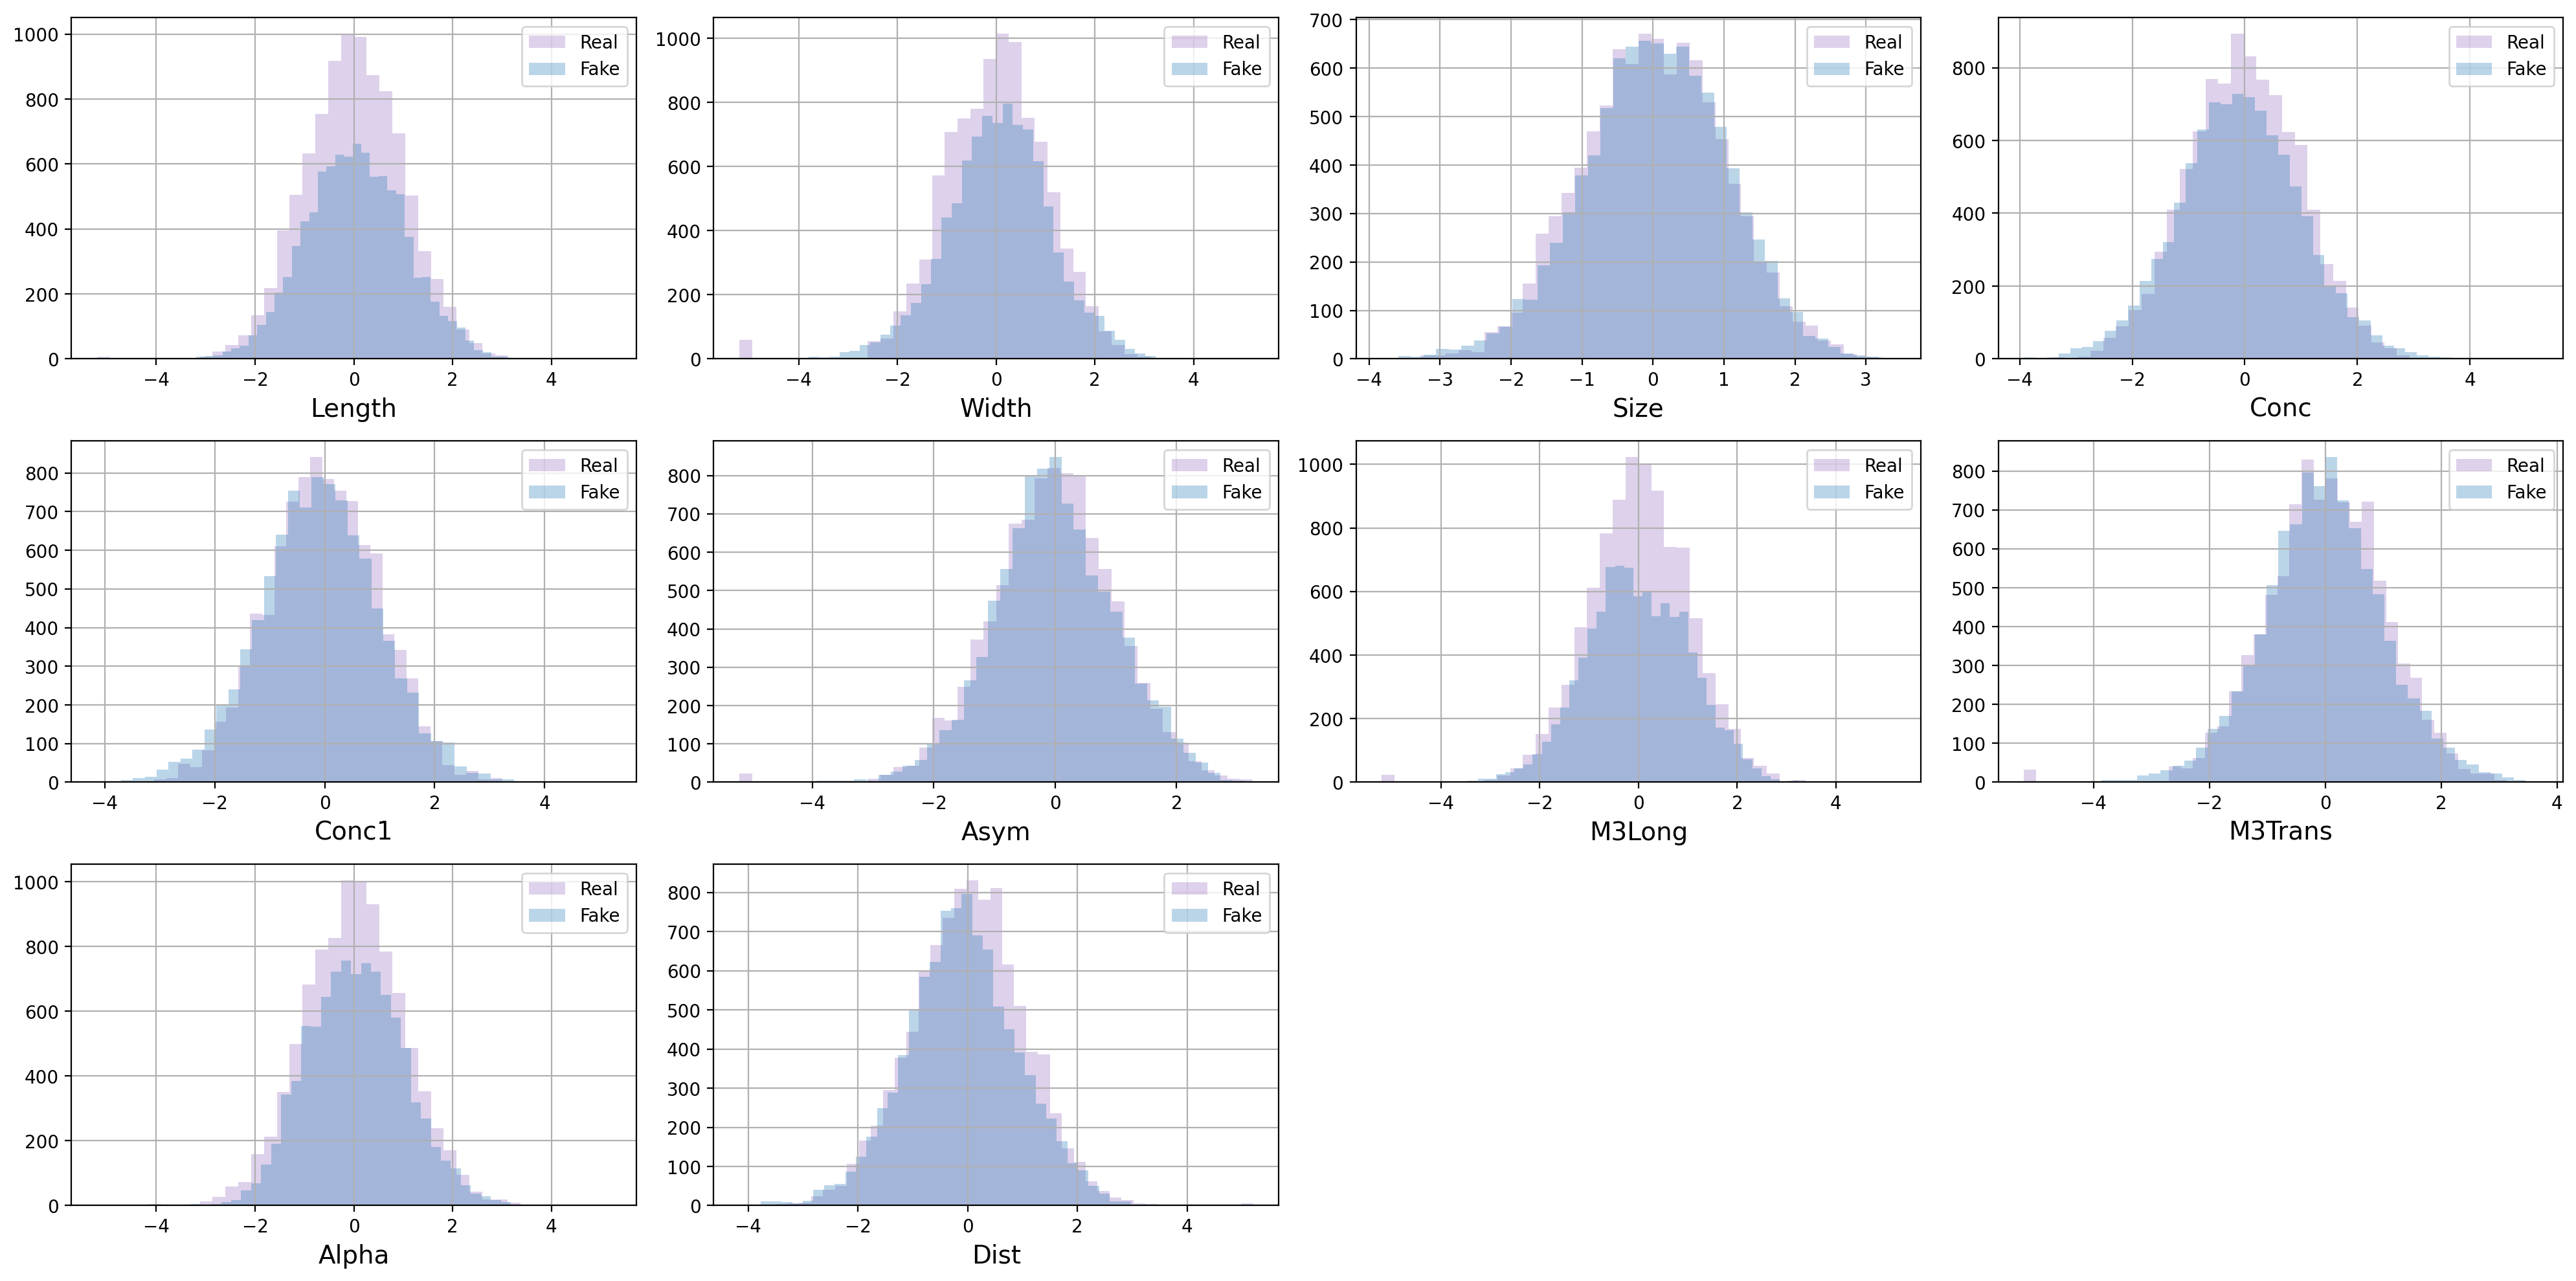

In [316]:
plot_hists(X_test_norm, X_fake_test_norm, names, label1="Real", label2="Fake", bins=40)

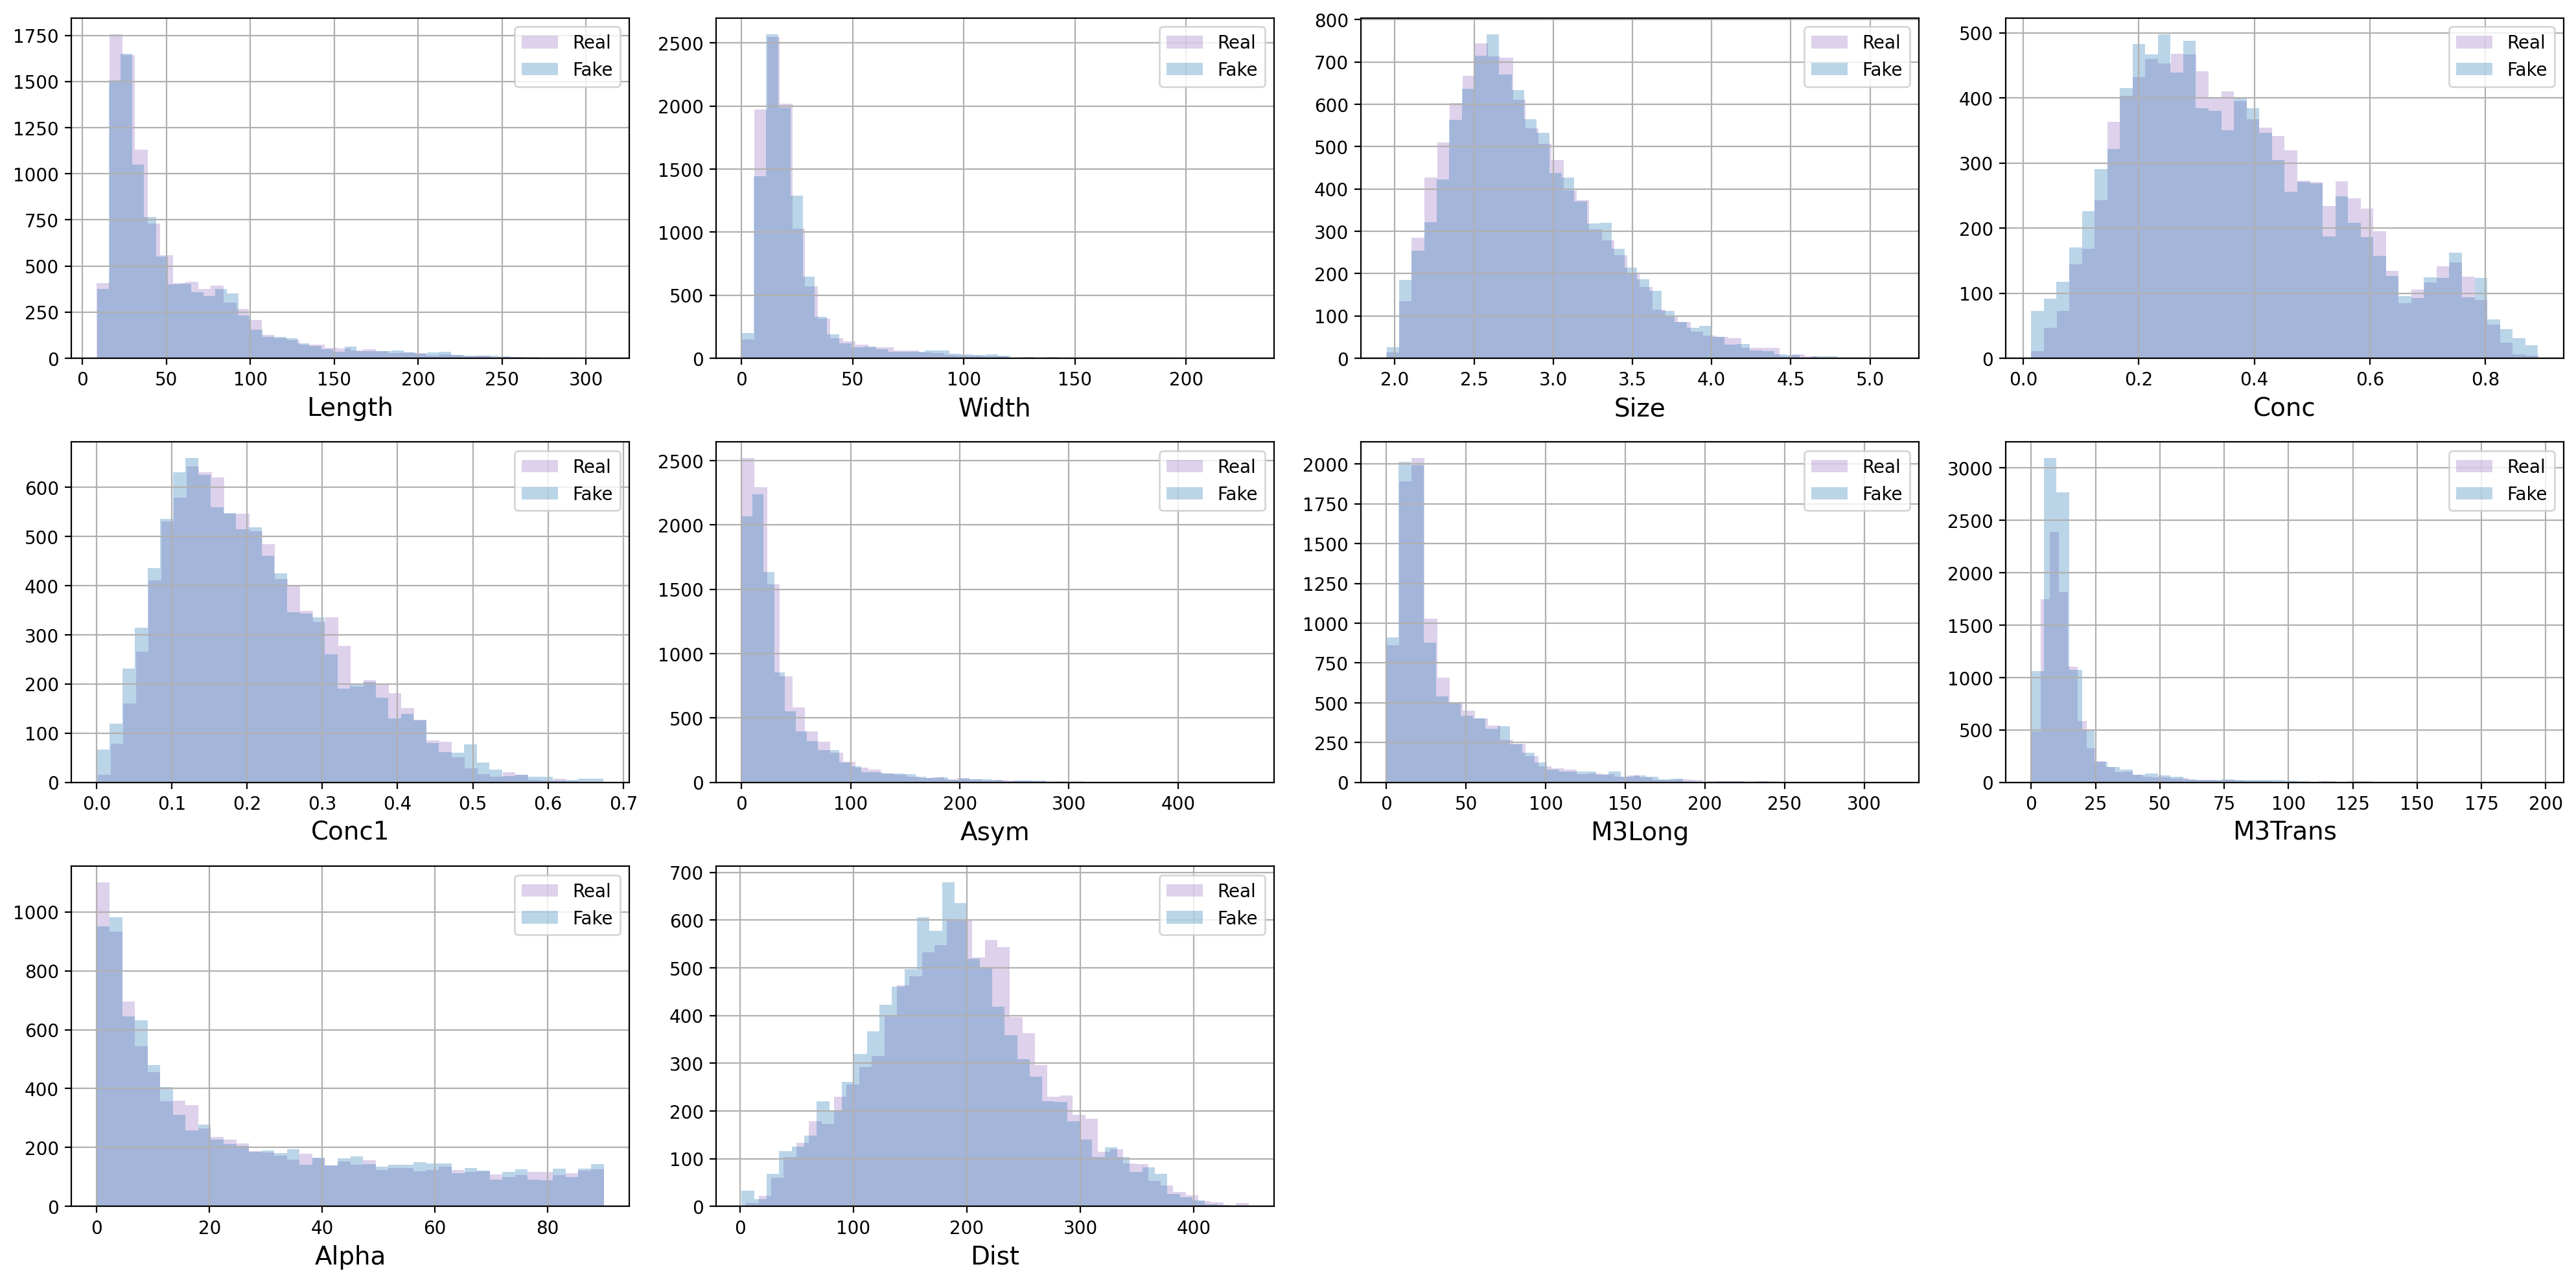

In [315]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=40)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [306]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [307]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [308]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6849338236025833


**Сколько параметров** было в модели?

In [320]:
print('Параметров у WGAN:', sum([p.numel() for p in fitter.generator.parameters()]) + sum([p.numel() for p in fitter.discriminator.parameters()]))

Параметров у WGAN: 24212


Очень мало.

## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?

### Подготовка
Я потратил немного времени на написание архитектур генератора и дискриминатора, поскольку основная информация про них уже была дана.

Я потратил некоторое время на написание функции `generate`, поскольку изначально не совсем правильно трактовал назначение параметра `latent_dim` — было не до конца понятно, нужно ли уже подавать в функцию шум, или он должен генерироваться внутри нее.

В написании `other_agent_score` было потрачено много сил на то, чтобы сделать правильные сплиты и конкатинировать данные в нужной последовательности, ничего не перепутать. В дальнейшем мне пришлось исправить ее, сделав правильный перевод данных на нужный девайс. Кроме того, после ряда экспериментов я для удобства решил добавить в эту функцию `return`, чтобы **выводить графики** обучения генератора и дискриминатора, как в семинарской тетрадке.

Изначально я не пранировал создавать отдельную *функцию для подсчета лосса* WGAN, но затем сделал это для упрощения кода обучения.

*Класс для обучения* было написать не так сложно, поскольку для него был дан хороший шаблон и основная информация. Однако у меня заняло много времени **ошибка** в методе `.backward()` — PyTorch ругался на то, что я пытался несколько раз сделать бэквард или обратиться к удаленным тензорам (точнее к их градиентам). Как оказалось далее, проблема была в том, что я пытался сделать несколько итераций обучения дискриминатора по одному батчу — это затрудняло алгоритм градиентного спуска и автоматического дифференцирования в PyTorch.

### Про эксперименты
После долгого дебаггинга проблемы с `.backward()` я несколько раз протестировал работу класса **на одной эпохе**.

Далее, более серьезно, я запускал **10 эпох** обучения WGAN. Они учились быстро, и качество **ROC AUC** получалось в районе **0.8-0.85**, но визуально (по гистограммам) данные приближались относительно неплохо. 

После ряда экспериментов я решил обновить класс обучения и добавить туда *визуализацию лосса* генератора, дискриминатора и скора регрессии с бустингом. Во-первых, потому что печать их скоров занимала место, во-вторых, чтобы лучше отслеживать и контролировать процесс обучения. Для того, чтобы совместить все три графика, я решил отрисовывать лоссы генератора и дискриминатора раз в эпоху, вместе с регрессией и бустингом.

Кроме того, для интереса и коррекности я всегда отдельно смотрел на гистограммы данных в изначальном и преобразованном видах. Скор (ROC AUC) для них получался практически идентичный.

Я несколько раз запускал итоговую реализацию моделей на **100 эпохах**. Локально они отрабатывали в среднем за 5 минут и выдавали качество **ROC AUC около 0.69-0.71**. Интересно, что логистическая регрессия уже после пары эпох практически стабильно выдавала accuracy около 0.5, а вот бустинг — где-то к 60 эпохе выходил на плато около 0.6 и очень плавно спускался.

В конце я попробовал запустить модель на **300 эпохах** и получил **лучший результат**: `ROC AUC = 0.68`. Модель обучалась 10 минут, что довольно быстро. По графику обучения можно увидеть, что градиентный бустинг почти сравнялся по скору с логистической регрессией (т.е. максимально приблизился к `accuracy = 0.5`).

#### Итог
Оцениваю результаты как хорошие, но не идеальные. Визуально (по гистограммам) сходство высокое, но тоже не идеальное. Причем сходство в преобразованных данных (через скейлер, т.е. в нормальном виде) несколько хуже, чем в исходных (спойлер: у диффузионной модели будет наоборот).

Пожалуй, лучшим вариантом был бы ROC AUC около 0.5, как и с accuracy, потому что он соответствовал бы случайному угадыванию. Учитывая, что градиентный бустинг — мощная модель, это означало бы, что у нас действительно получилось хорошо генерировать синтетические данные. У нас он получился около 0.68-0.69, что не так много, но и не идеально (с т.з. генерации). Но зато этот результат получался очень быстро.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

Я *обновлю обучающую и тестовые выборки*, поскольку на предыдущем шаге они были трансформированы обратно.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

QuantTrans = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=13).fit(X_train)

X_train = QuantTrans.transform(X_train)
X_test = QuantTrans.transform(X_test)

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [18]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    num_obj, dim = x.shape       # число объектов и их размерность
    amount = amount.view(-1, 1)  # у нас только две размерности, т.к. работаем с табличными данными
    
    x = x * (1 - amount) + noise * amount  # зашумляем
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [340]:
# !pip install -q diffusers

In [19]:
from diffusers import DDPMScheduler

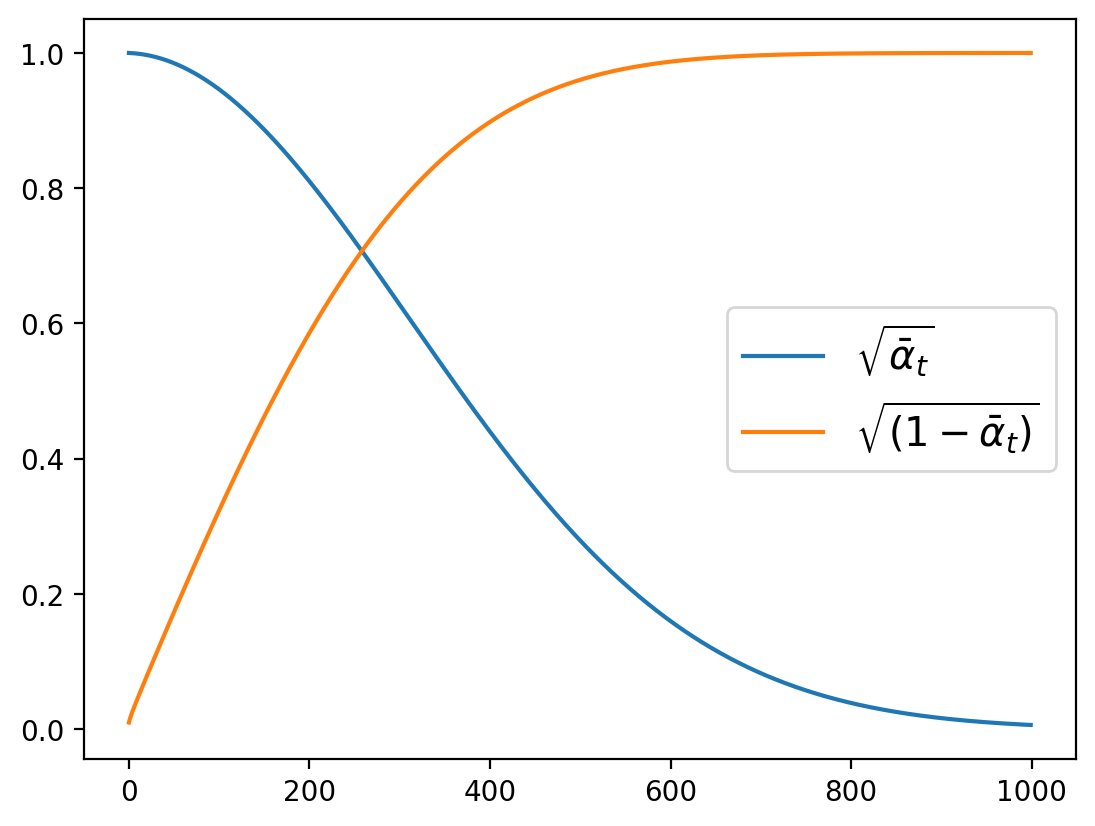

In [20]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=True, clip_sample_range=3.0)  # поставил clip_sample_range, чтобы обрезать полученные значения 
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")           # и не получать численные проблемы
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

**Ответ**: качество можно измерять так же по близости ROC AUC к 0.5, как раньше, по по близости метрики accuracy обучаемых логистической регрессии и град. бустинга, а также по MSE (ведь мы работаем с табличными данными).

In [27]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs, class_emb_size=4, time_emb_size=16):
        super(DiffusionGenerator, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # я добавил эмбединги для класса и шага времени, как в статье DDPM
        self.class_emb = nn.Embedding(2, class_emb_size)
        self.time_emb = nn.Embedding(1000, time_emb_size)

        # я немного усложнил базовую модель: добавил дропаут и несколько полносвязных слоев
        self.net = nn.Sequential(
            nn.Linear(n_inputs + class_emb_size + time_emb_size, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(300, 300),
            nn.BatchNorm1d(300),
            nn.ReLU(),
            nn.Dropout(0.15),

            nn.Linear(300, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 60),
            nn.BatchNorm1d(60),
            nn.ReLU(),

            nn.Linear(60, n_outputs)
        )

    def forward(self, z, t, y):
        # получаем эмбединги из класса и шага
        time_cond = self.time_emb(t)
        class_cond = self.class_emb(y.squeeze())
        # конкатенируем полученные данные
        zyt = torch.cat((z, class_cond, time_cond), dim=1)
        return self.net(zyt)  # размер (bs, n_outputs)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [23]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    model = model.to(DEVICE).eval()                      # переносим модель на устройство, переводим в валидационный режим  
    num_objects = y.shape[0]                             # число объектов
    x = torch.randn(num_objects, latent_dim).to(DEVICE)  # генерируем нормальный шум, переносим на устройство

    for i, t in tqdm(enumerate(sheduler.timesteps)):     
        with torch.no_grad():
            t = t.to(DEVICE)                             # переносим шаги на устройство
            t_vec = (torch.ones(num_objects,).to(DEVICE) * t).long().to(DEVICE)  # создаем вектор из (одинаковых) шагов, чтобы делать шаг по каджому объекту
            residual = model(x, t_vec, y.long())         # предсказываем шум, как в статье
        x = sheduler.step(residual, t, x).prev_sample    # делаем шаг от шума к данным, забираем атрибут .prev_sample, где лежат данные

    X_fake = x                                           # это расшумленные предсказанные данные
    
    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

Проиллюстрирую работу **расписания для `lr`**, которое я добавил в свою модель:

In [46]:
# иллюстрация для шедулера взята из семинара № 4 курса ОГО

model_shed = torch.nn.Linear(1, 1)

def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.Adam(model_shed.parameters(), lr=0.001) # 
    return simple_model, simple_optimizer

# "учимся" 300 эпох
def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(300):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(300), lrs)

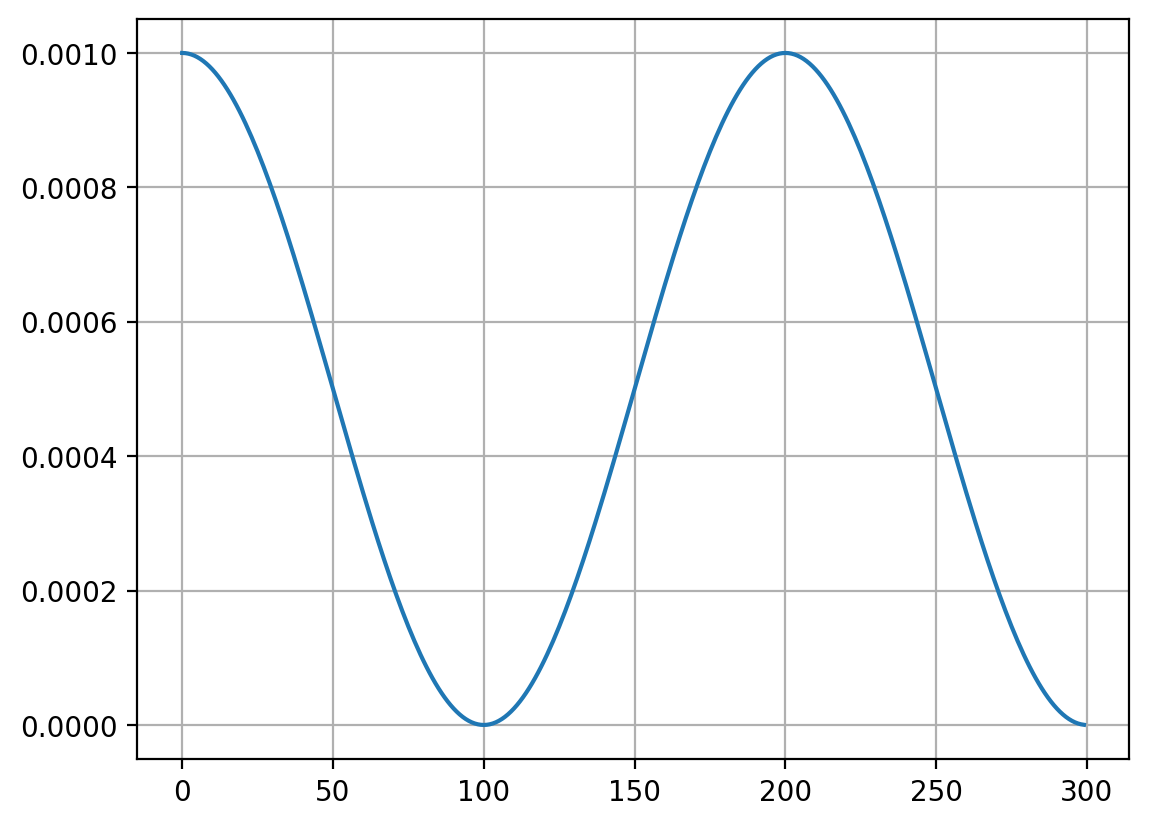

In [49]:
# работа на 300 эпохах
model_shed, optimizer_shed = get_simple_model_optimizer()
scheduler_test = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_shed, T_max=100, eta_min=0)  # batch 256
draw_learning_rate_curve(optimizer_shed, scheduler_test)

In [58]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.loss_fn = nn.MSELoss(reduction='sum')  # беру сумму, а не среднее, чтобы в конце честно считать средний лосс по эпохе,
                                                    # а не среднее средних по батчу        
        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        # добавлен шедулер
        self.scheduler_lr = torch.optim.lr_scheduler.CosineAnnealingLR(self.opt_gen, T_max=100, eta_min=0, verbose=False) # batch 256

        self.model.to(DEVICE)

    def fit(self, X, y):
        # заводим счетчик итераций
        iter_i = 0

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.gen_loss_trace = []
        self.lin_reg_score_trace = []
        self.boosting_score_trace = []
        self.loss_history = []

        # Fit Diffusion
        for epoch in range(self.n_epochs):
            # печатаем номер эпохи
            print(f'Эпоха: {epoch} из {self.n_epochs}')
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                # переносим реальные объекты на устройство
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.long().to(DEVICE)
                # генерируем шум, шаги и новые объекты
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, 999, (real_batch.shape[0],)).long().to(DEVICE)
                noisy_x = noise_scheduler.add_noise(real_batch, noise, timesteps)
                # предсказываем шум, как в статье DDPM
                pred = self.model(noisy_x, timesteps, cond_batch)
                # делаем градиентный шаг
                self.opt_gen.zero_grad()
                gen_loss = self.loss_fn(pred, noise)
                gen_loss.backward()
                self.opt_gen.step()
                # добавляем лосс по батчу
                self.gen_loss_trace.append((iter_i, gen_loss.item() / real_batch.shape[0]))
                # добавляем лосс для подсчета лосса по эпохе
                loss_epoch += gen_loss.item()
                
                iter_i += 1

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch / X_real.shape[0])  # считаем корректный лосс по эпохе
            
            # Создаем выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запускаем работу фукнции other_agent_score
            
            ## создаем выборку
            idx = torch.randint(0, X_real.shape[0], (1000,))
            X_real_sub = X_real[idx]  # это X_train
            y_cond_sub = y_cond[idx]  # это y_train
            ## генерируем фейковые данные
            X_fake = generate_with_diffusion(self.model,
                                             y_cond_sub,
                                             self.latent_dim,
                                             noise_scheduler)

            ## запускаем фунцкию other_agent_score()
            lin_reg_score, boosting_score = other_agent_score(X_real_sub, y_cond_sub, X_fake, y_cond_sub)
            self.lin_reg_score_trace.append((epoch, lin_reg_score))
            self.boosting_score_trace.append((epoch, boosting_score))

            ## визуализация результатов эпохи
            clear_output(wait=True)
            plt.figure(figsize=(15, 5))
            
            # лосс генератора
            plt.subplot(1, 2, 1)
            plt.xlabel("Iteration")
            plt.ylabel("Generator loss")
            plt.ylim(top=12)
            plt.plot([p[0] for p in self.gen_loss_trace], 
                     [p[1] for p in self.gen_loss_trace]
                     )

            # лосс моделей
            plt.subplot(1, 2, 2)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.plot([p[0] for p in self.lin_reg_score_trace],
                     [p[1] for p in self.lin_reg_score_trace],
                     label='LogisticRegression score',
                     color='green')
            plt.plot([p[0] for p in self.boosting_score_trace],
                     [p[1] for p in self.boosting_score_trace],
                     label='GradientBoosting score',
                     color='red')
            plt.legend(loc="best")

            plt.show()
            # меняем lr
            self.scheduler_lr.step()
            
        # Turn off training
        self.model.train(False)

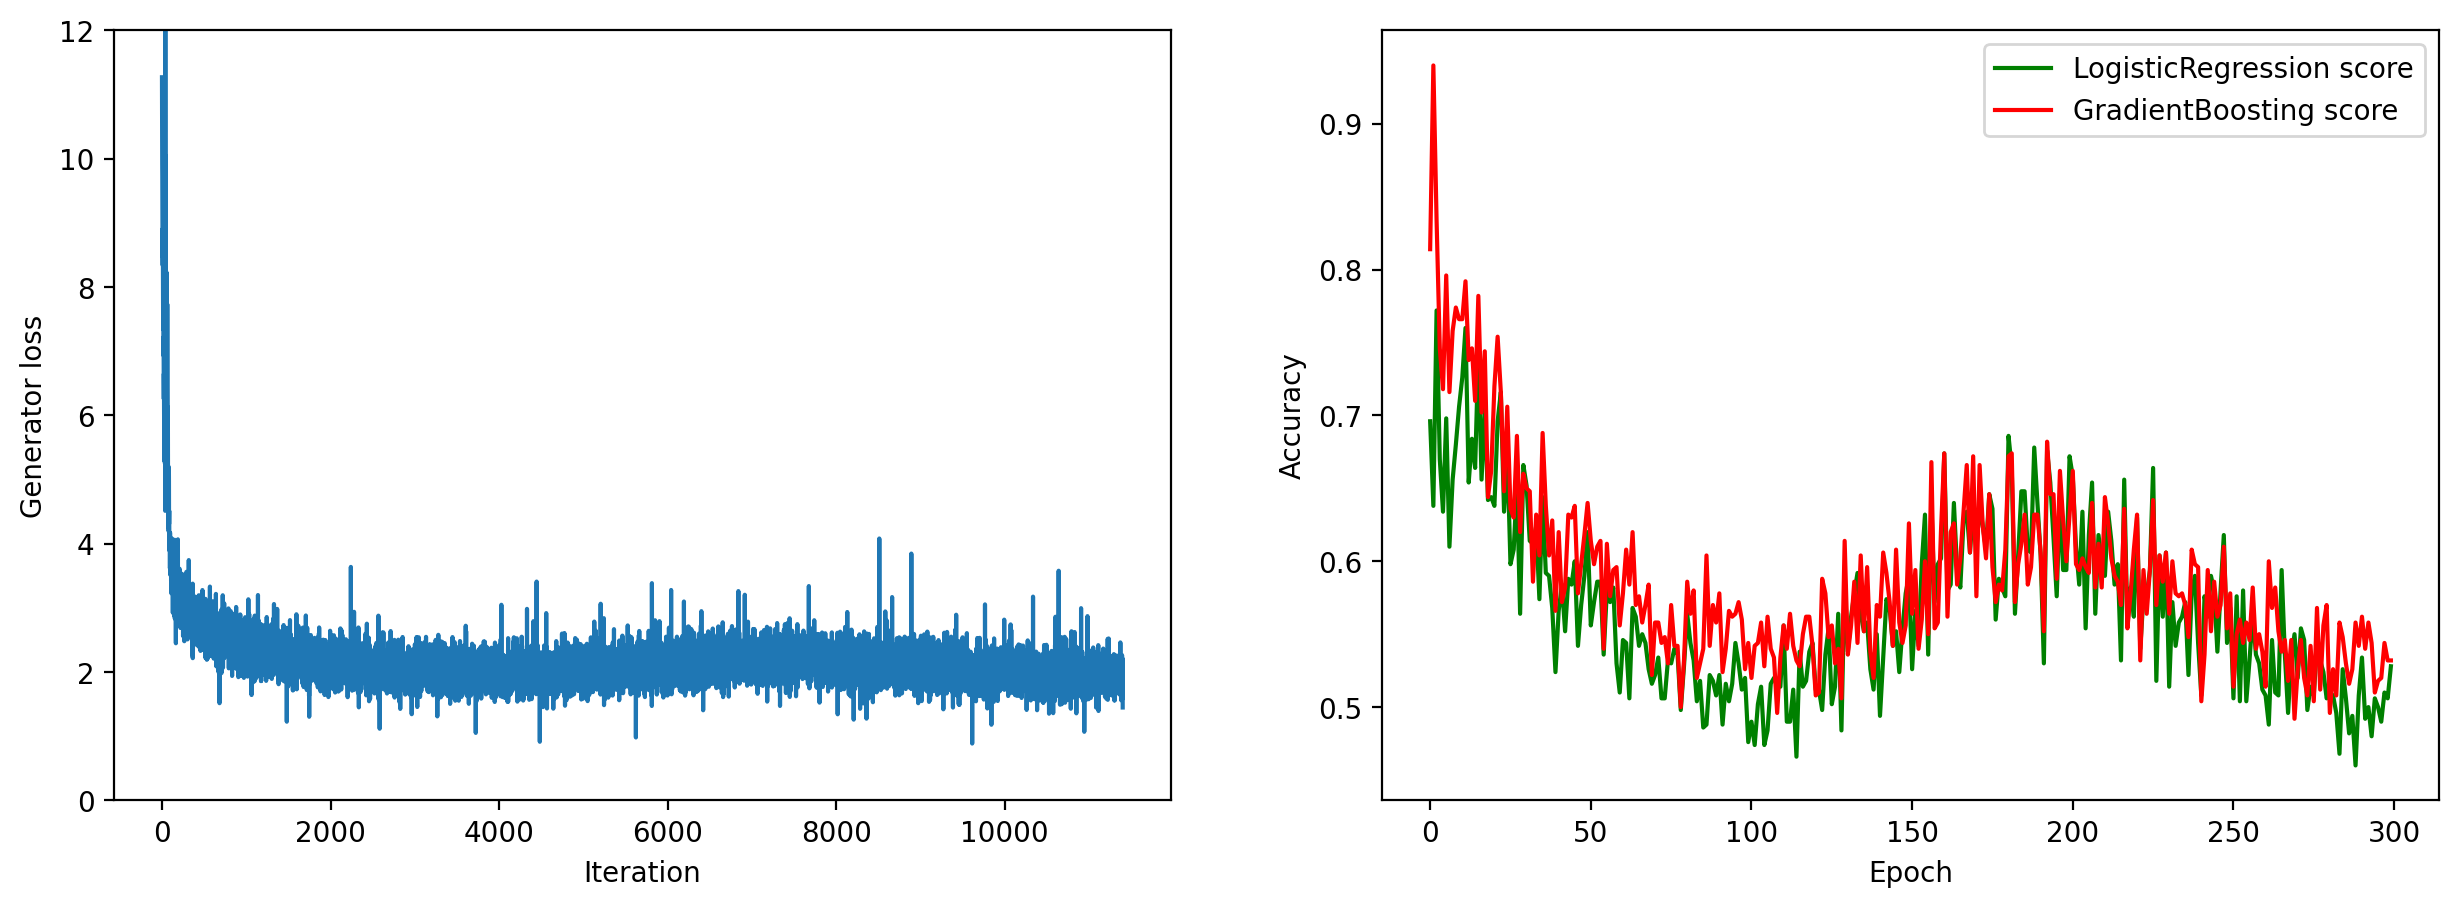

CPU times: total: 18min 39s
Wall time: 18min 57s


In [59]:
%%time
latent_dim = 10
class_emb_size=16
time_emb_size=256

model = DiffusionGenerator(n_inputs=latent_dim,
                    n_outputs=X_train.shape[1],
                    class_emb_size=class_emb_size,
                    time_emb_size=time_emb_size)

diffusionFitter = DiffusionFitter(
    model,
    batch_size=256,
    n_epochs=300,
    latent_dim=latent_dim,
    lr=0.001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

In [65]:
print('Параметров у диффузионной модели:', sum([p.numel() for p in diffusionFitter.model.parameters()]))

Параметров у диффузионной модели: 487672


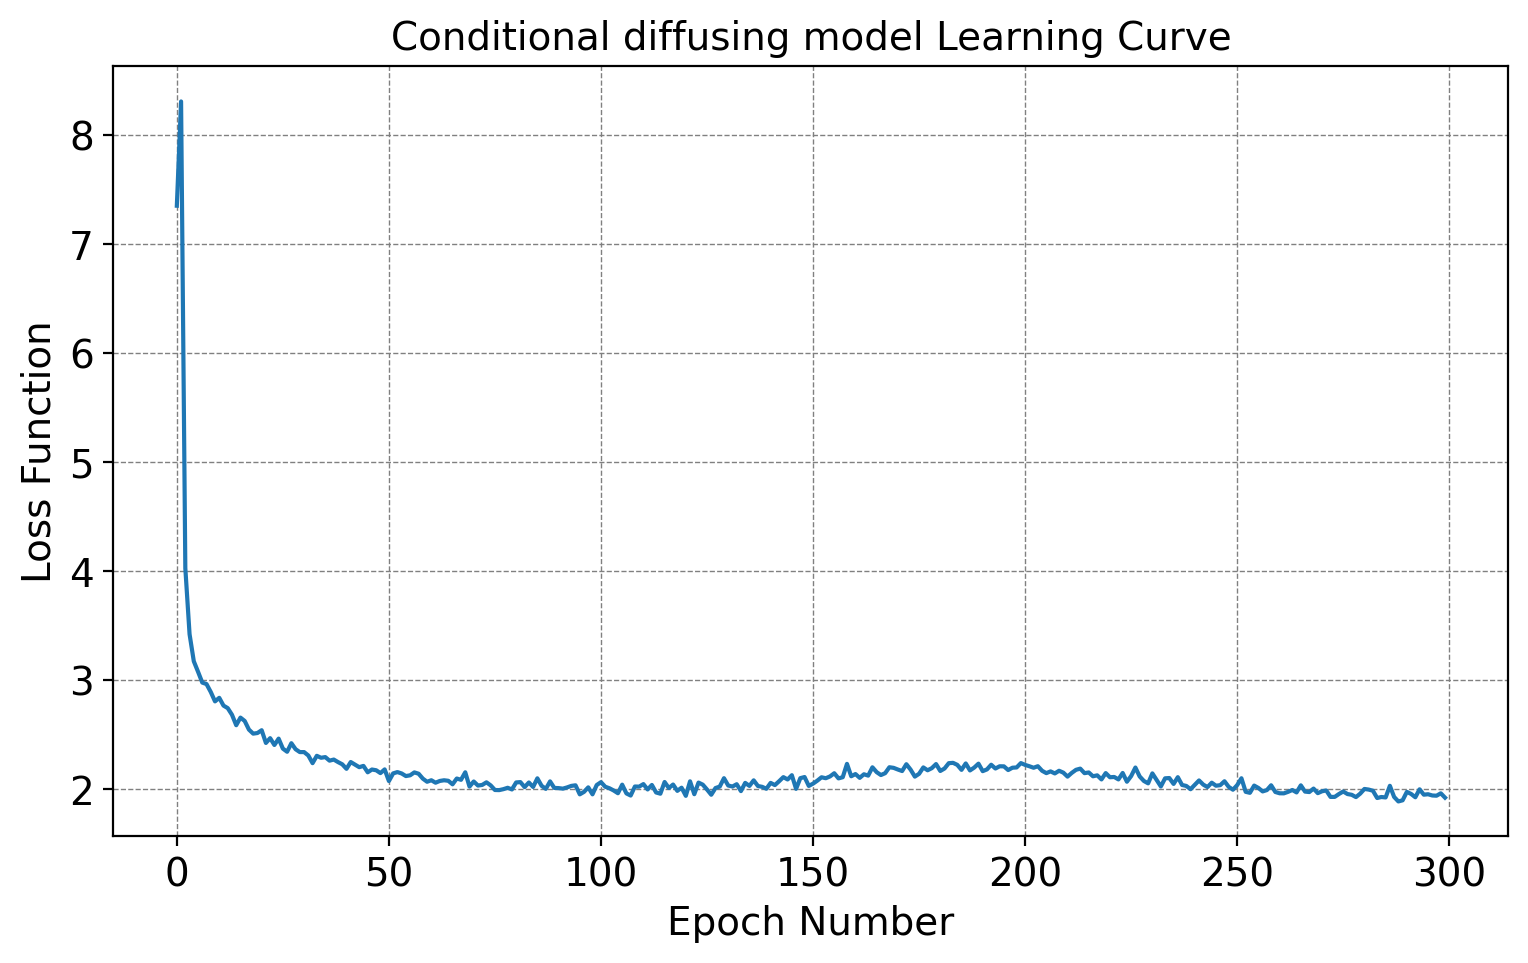

In [61]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

*Заметна работа косинусного расписания на `lr`!*

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

В начале, по аналогии с предыдущим блоком, посмотрим на получившиеся **гистограммы данных**. Для этого, как раньше сохраним предсказанные данные (в нормальном виде) и в трансформированном виде.

In [76]:
X_fake_train_norm = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_train, dtype=torch.float, device=DEVICE), latent_dim, noise_scheduler).detach().cpu().numpy()
X_fake_train = QuantTrans.inverse_transform(X_fake_train_norm)

X_train_norm = X_train.copy()
X_train = QuantTrans.inverse_transform(X_train_norm)

1000it [00:08, 116.56it/s]


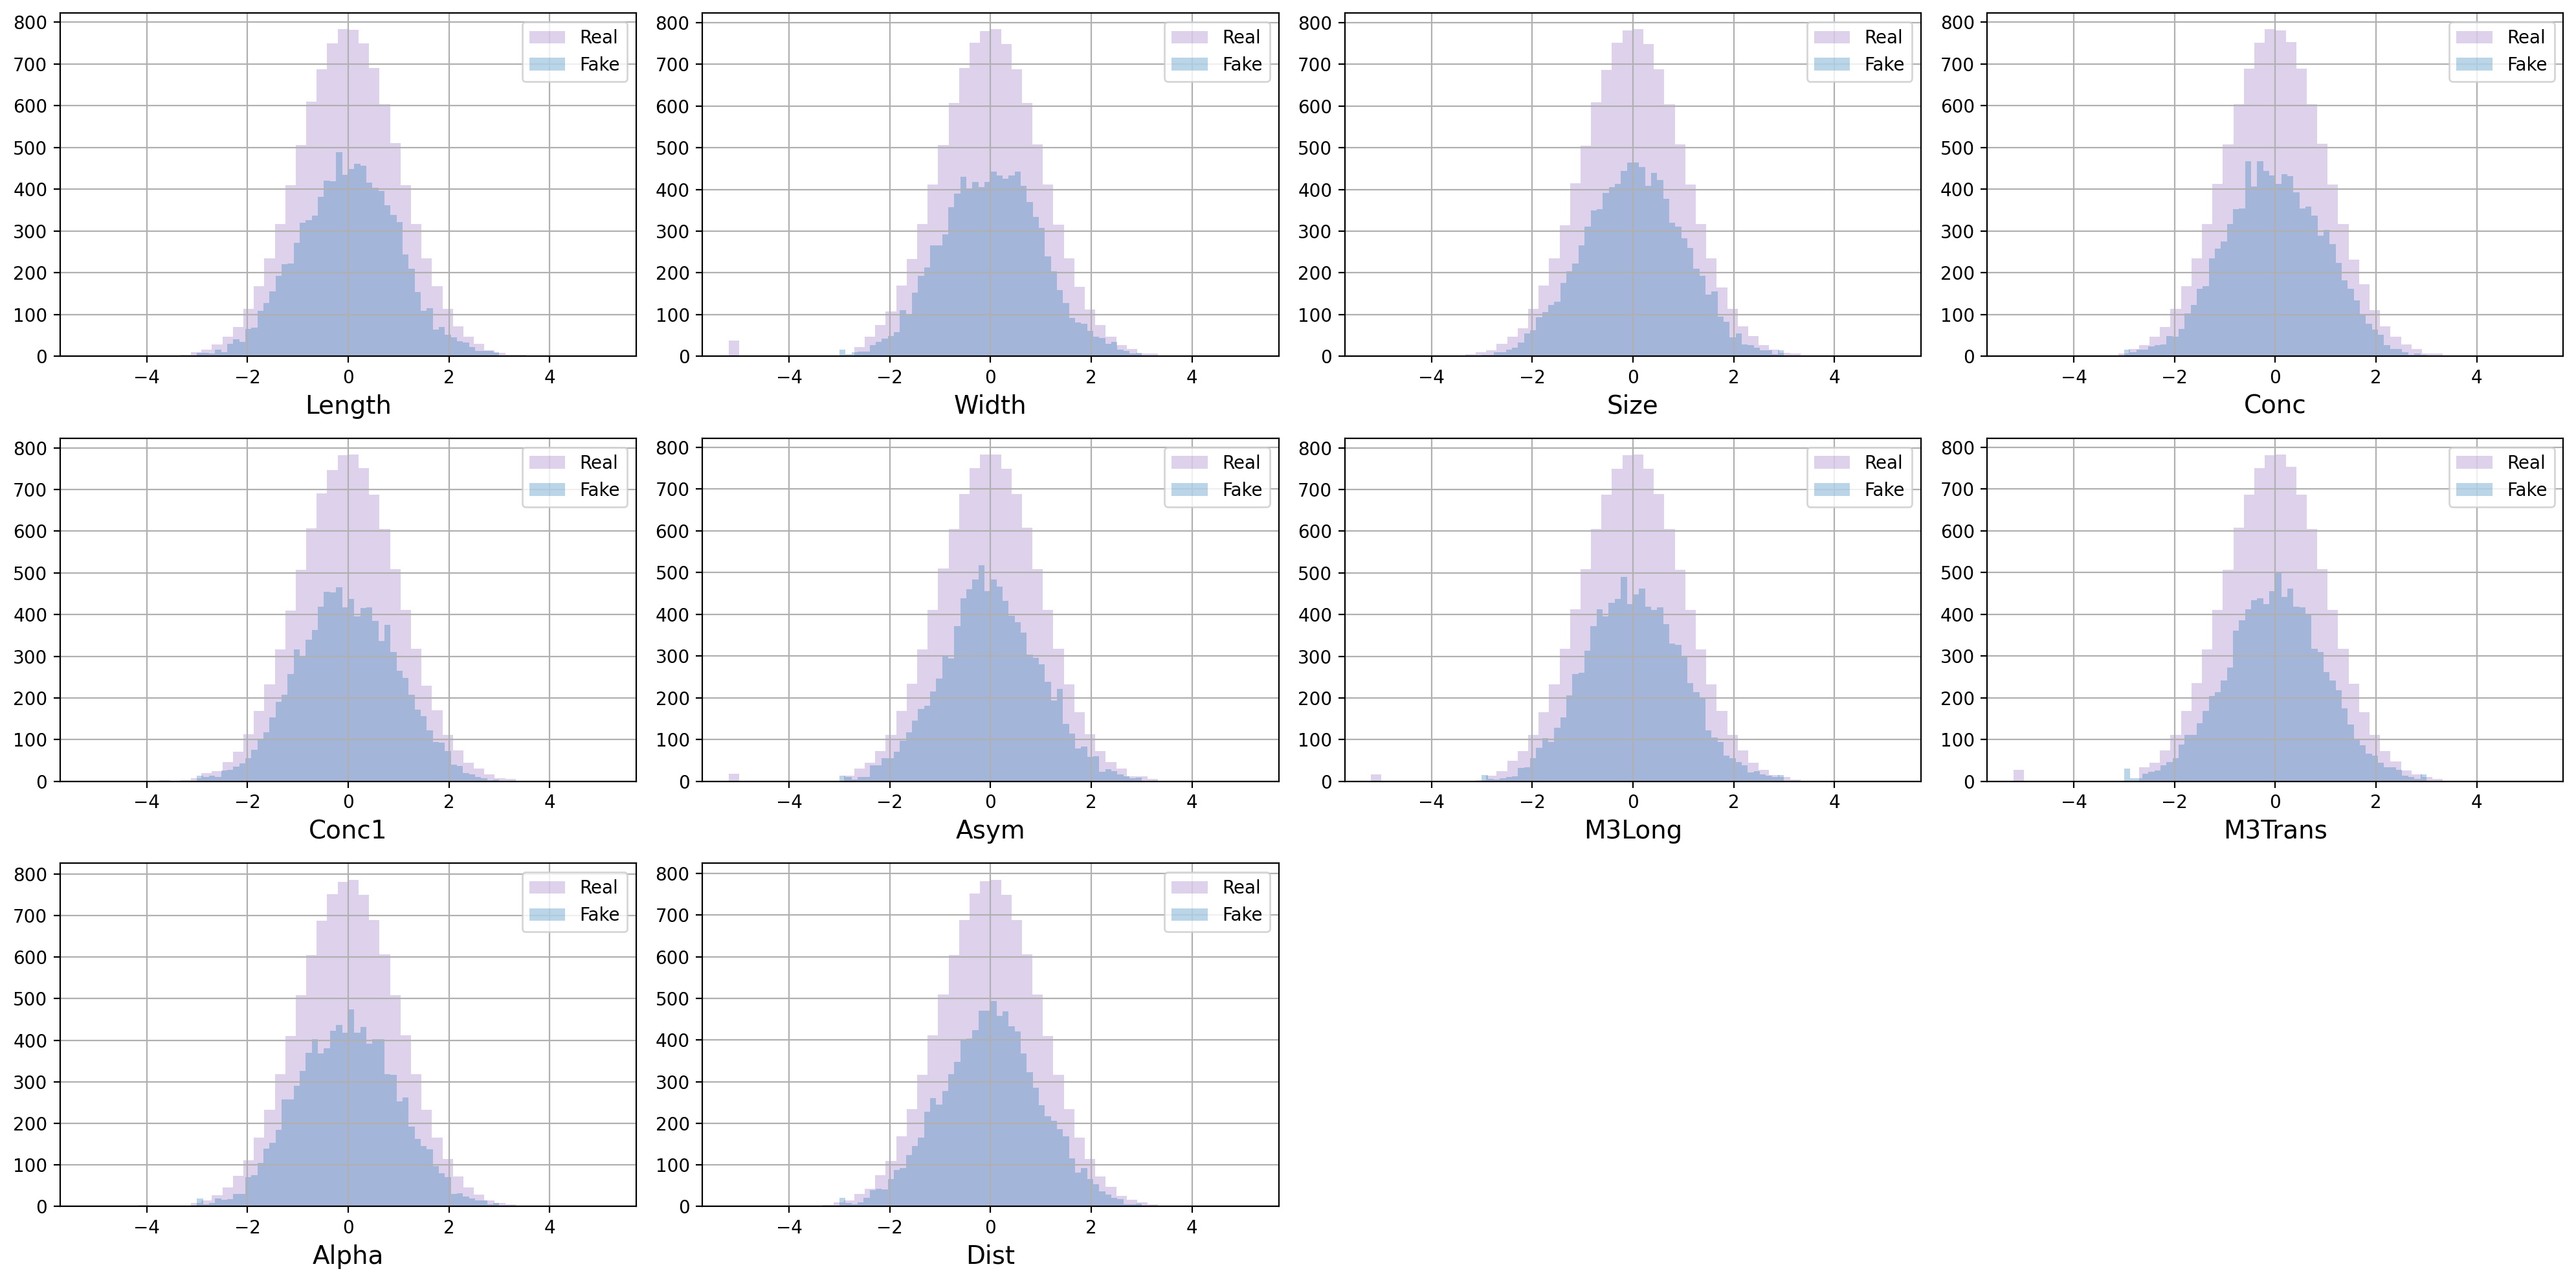

In [77]:
plot_hists(X_train_norm, X_fake_train_norm, names, label1="Real", label2="Fake", bins=50)

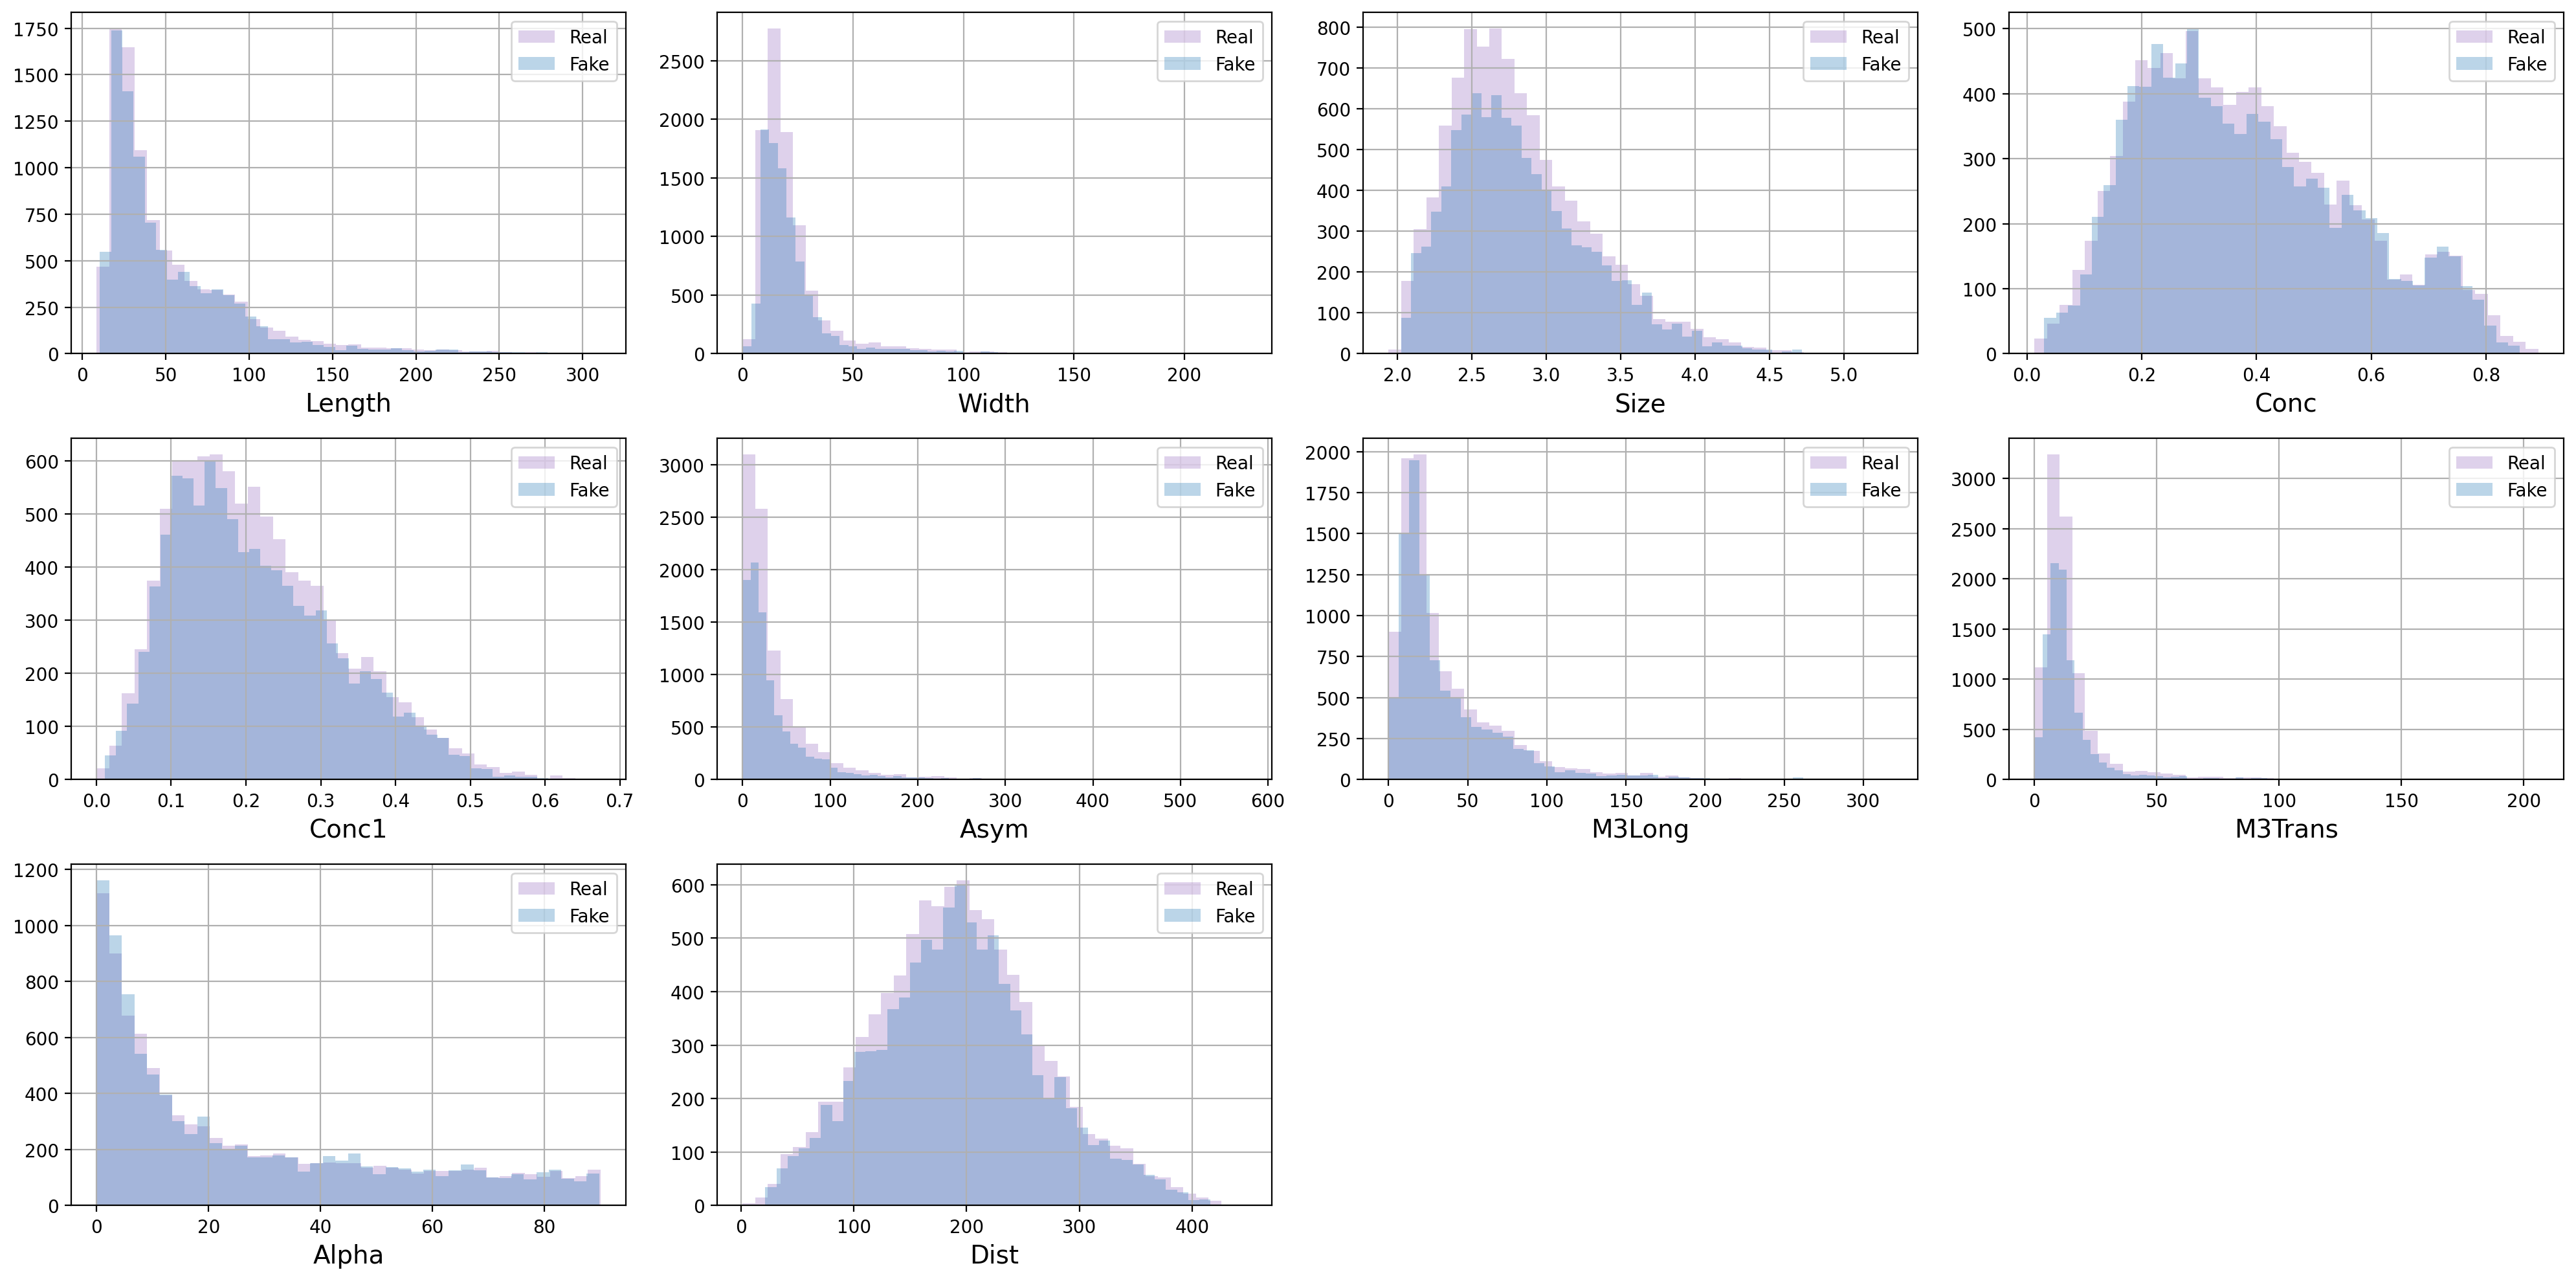

In [79]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=40)

In [80]:
X_fake_test_norm = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_test, dtype=torch.float, device=DEVICE), latent_dim, noise_scheduler).detach().cpu().numpy()
X_fake_test = QuantTrans.inverse_transform(X_fake_test_norm)

X_test_norm = X_test.copy()
X_test = QuantTrans.inverse_transform(X_test_norm)

1000it [00:08, 112.36it/s]


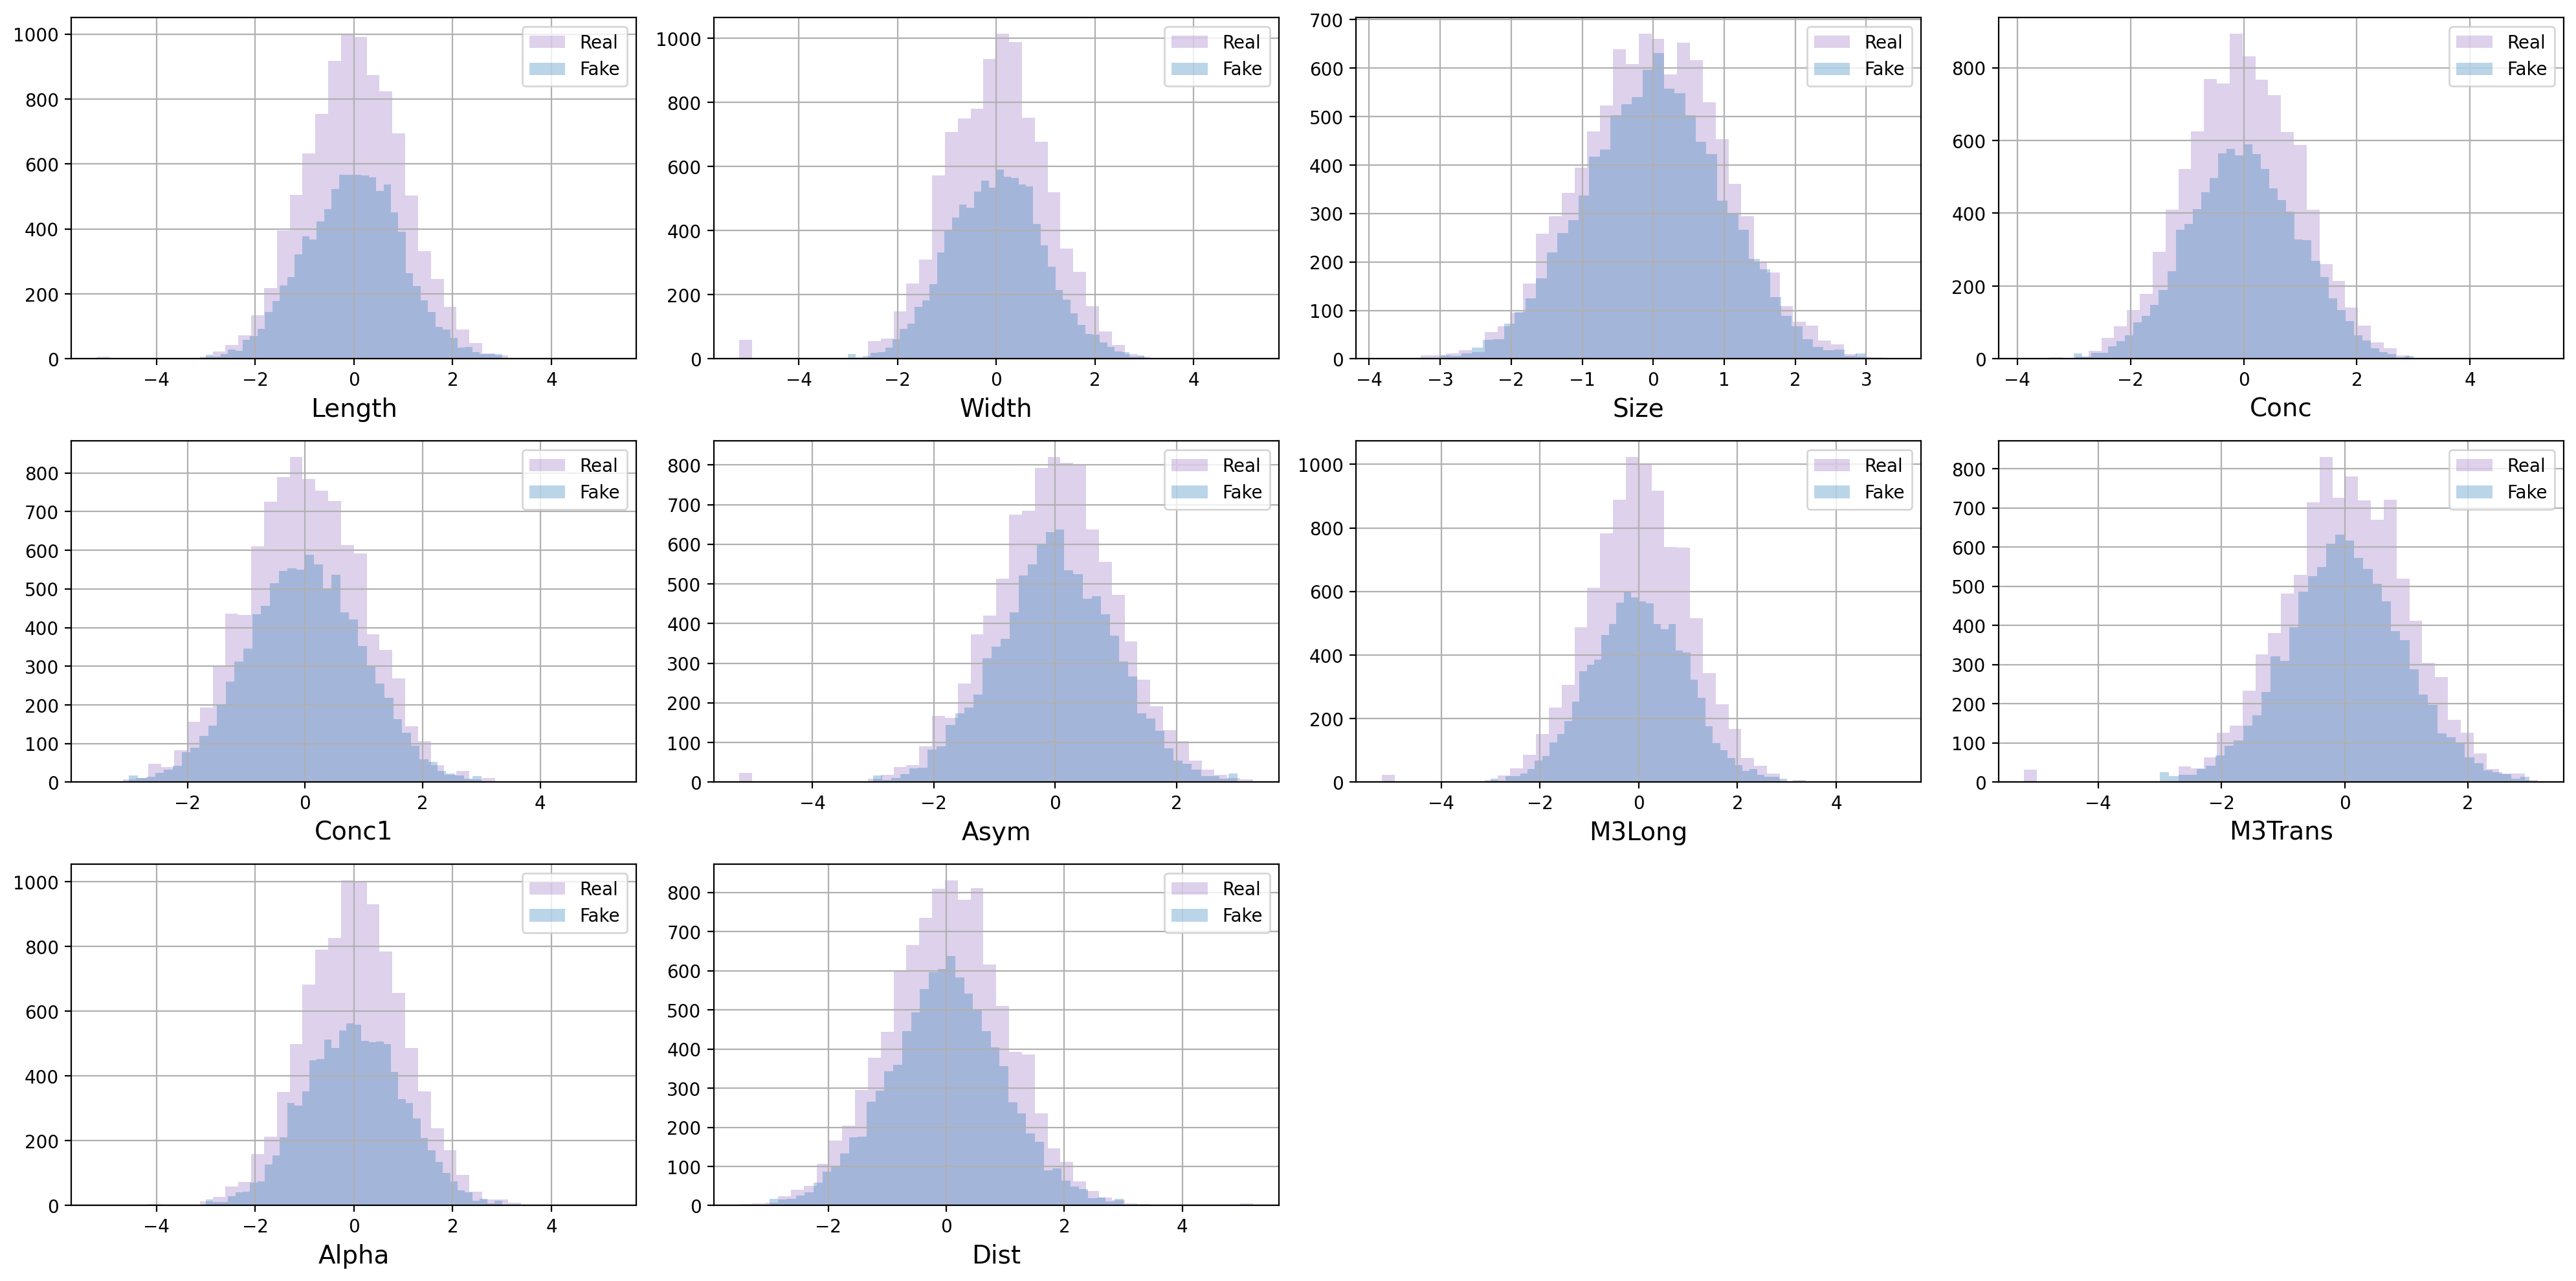

In [81]:
plot_hists(X_test_norm, X_fake_test_norm, names, label1="Real", label2="Fake", bins=40)

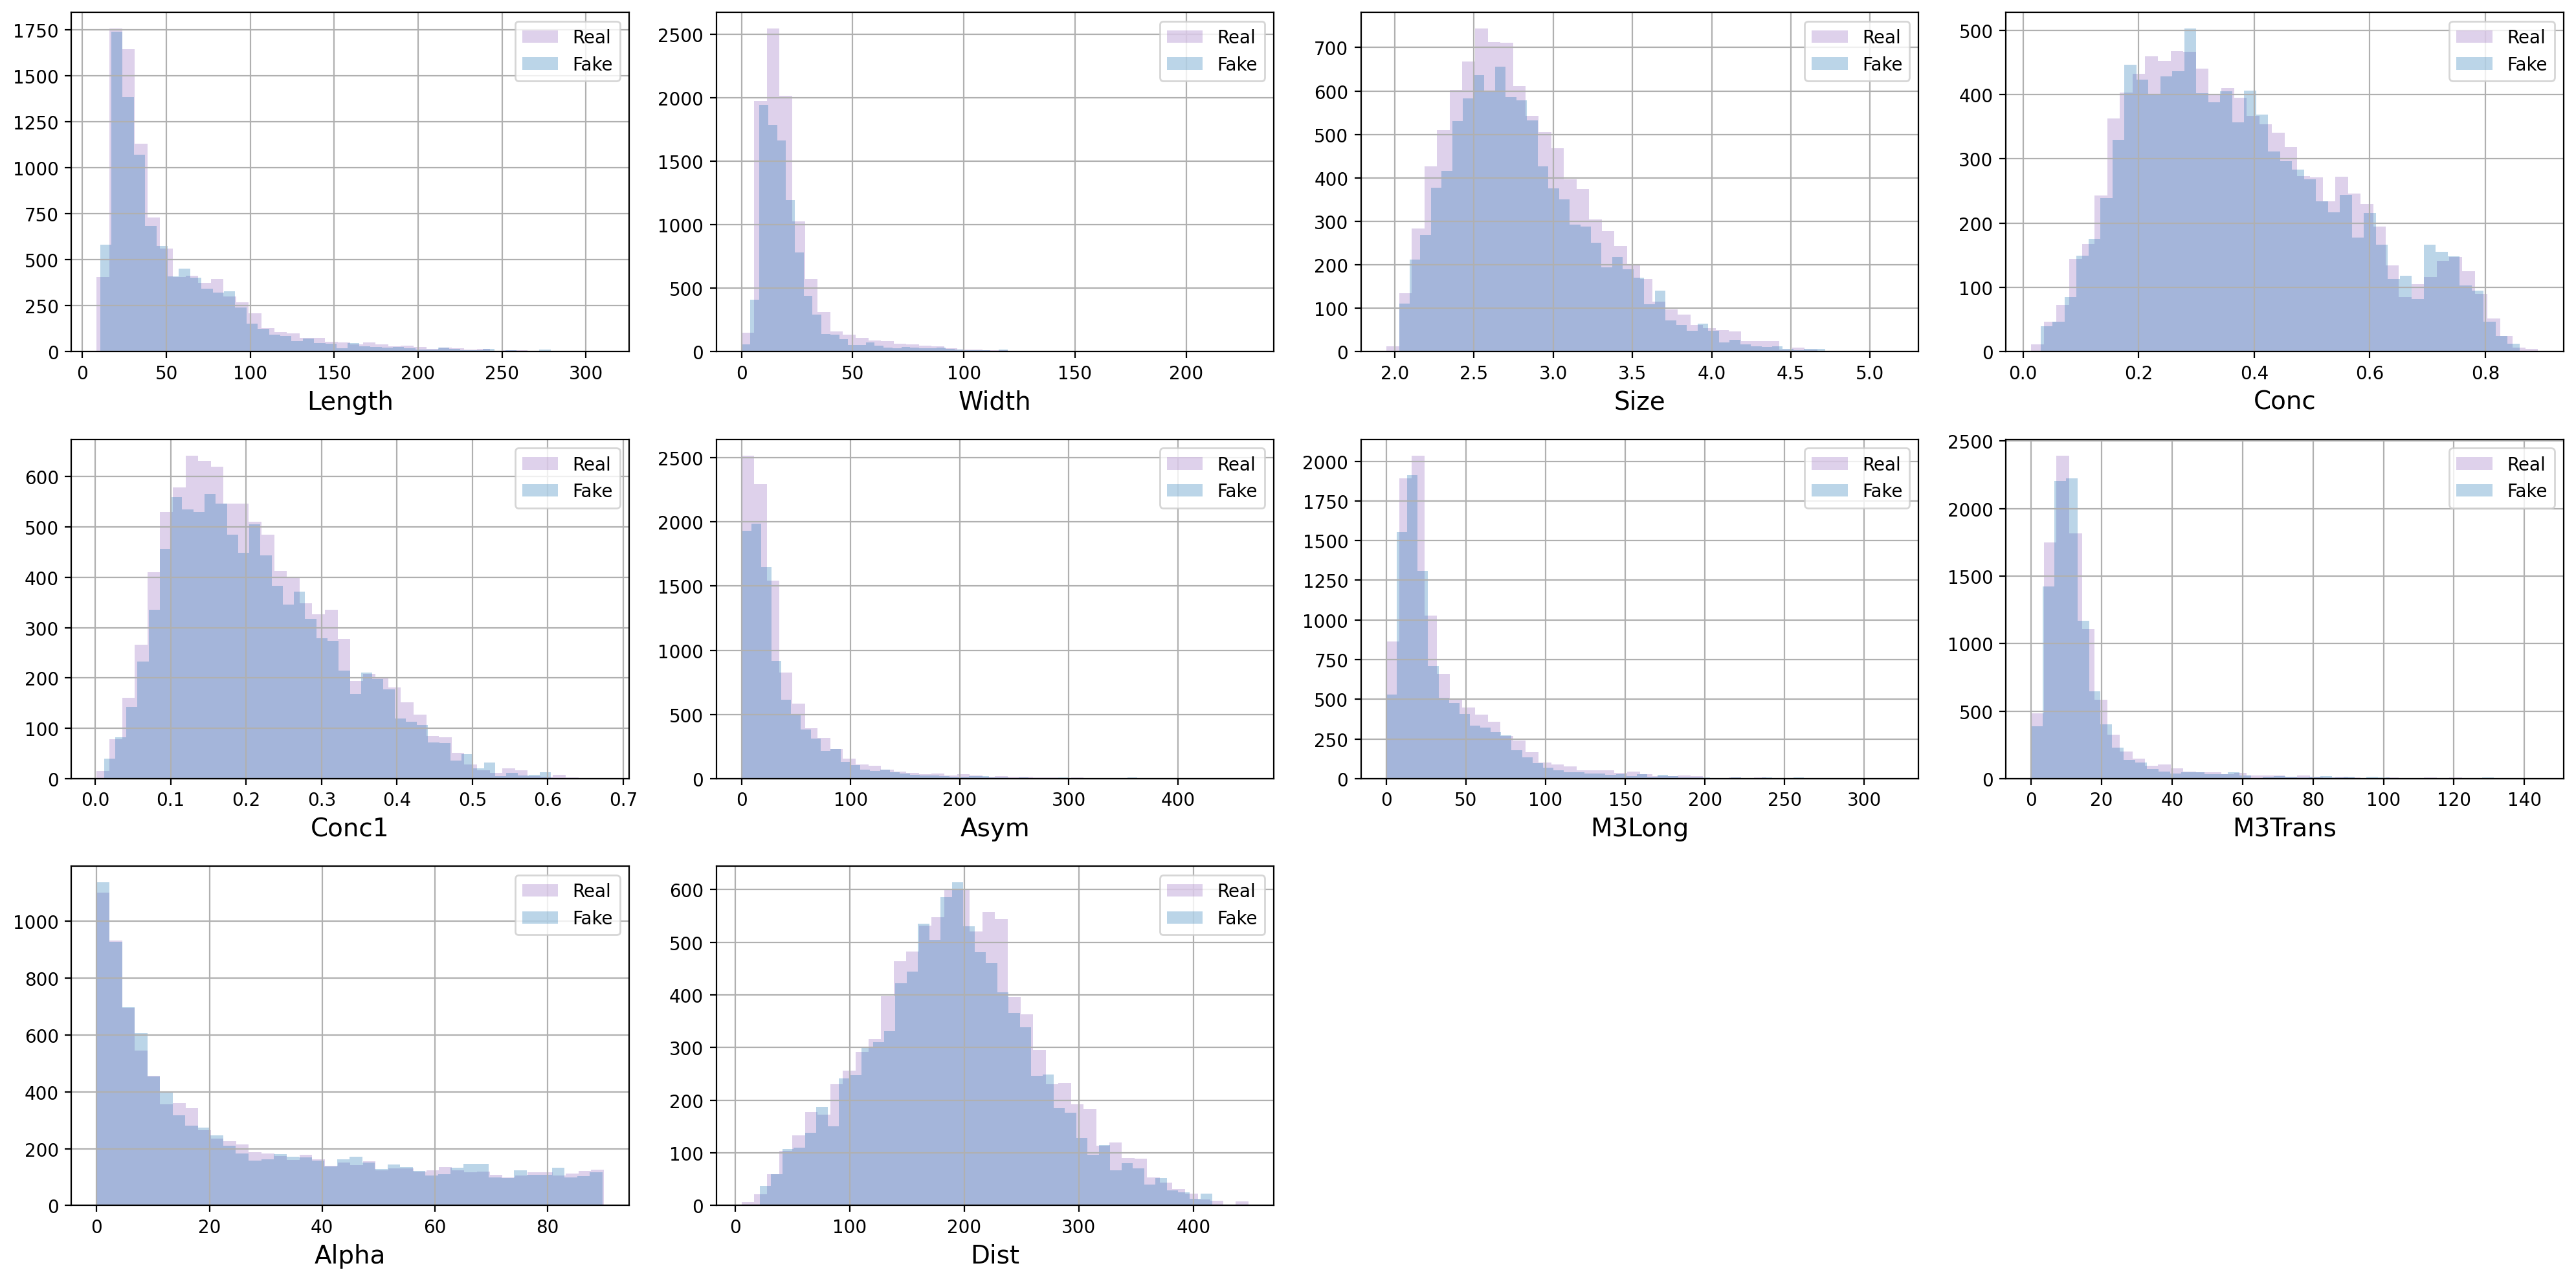

In [82]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=40)

Видим **хорошее сходство**. Теперь измерим **качество генерации** (с помощью AUC ROC и accuracy):

In [83]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [84]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы-вероятности
yy_test_proba = clf.predict_proba(XX_test)[:, 1]
yy_train_proba = clf.predict_proba(XX_train)[:, 1]

# получаем прогнозы-метки
yy_test_pred = clf.predict(XX_test)
yy_train_pred = clf.predict(XX_train)

# считаем метрики
roc_auc_test = roc_auc_score(yy_test, yy_test_proba)
roc_auc_train = roc_auc_score(yy_train, yy_train_proba)

acc_test = accuracy_score(yy_test, yy_test_pred)
acc_train = accuracy_score(yy_train, yy_train_pred)

In [87]:
# печатаем
print("DIFFUSION RESULTS: \n")
print("ROC AUC test = ", roc_auc_test)
print("ROC AUC train = ", roc_auc_train)
print()
print("Accuracy test = ", acc_test)
print("Accuracy train = ", acc_train)

DIFFUSION RESULTS: 

ROC AUC test =  0.5894404086240506
ROC AUC train =  0.6505280235205402

Accuracy test =  0.553838065194532
Accuracy train =  0.5952681388012618


### Отчет
#### Подготовка

Я долго решал, какой вариант диффузионной модели реализовывать: проще (предсказывать сразу объект) или сложнее (предсказывать шум, как в статье DDPM). Внимательно изучив код с семинара, я выбрал второй вариант (спойлер — не пожалел).

Изначально я оставил *базовую архитектуру* генератора: 
```
nn.Sequential(
    nn.Linear(n_inputs + class_emb_size + time_emb_size, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, n_outputs),
)
```

Я добавил туда **два вида эмбедингов**: для метки класса (y) и отметки времени (t). По умолчанию и во время тестов я использовал небольшую размерности эмбедингов: 4 и 8 соответственно. Пришлось потратить некоторое время, чтобы правильно встроить эмбединги в модель.

Далее я потратил много времени на написание функции `generate_with_diffusion`. Заняло немало сил, чтобы правильно "расшумлять" сэплированный нормальный шум, а также правильно использовать `sheduler` из статьи DDPM. Как оказалось, у библиотеки Hugging Face не очень хорошая документация.

Написание тренировочного класса не заняло много времени, поскольку при обучении WGAN я уже довольно качественно реализовал его. Пришлось только немного покопаться, чтобы правильно генерировать фейковые данные из шума.

После небольшого дебаггинга (модель запустилась относительно быстро, пришлось только немного поработать с типом устройства (чтобы шум, временные шаги, таргеты лежали вместе) и типом данных (`sheduler` из статьи DDPM требует "тяжелый" тип данных long или int64)) я приступил к экспериментам.

#### Эксперименты
В начале я запускал обучение в тестовом режиме **на 1 и 10 эпохах**. Лосс иногда "скакал", поэтому я ограничил график лосса генератора значением 12 (в терминах MSE) сверху.

Во время первых серьезных запусков (**по 50 эпох**) я использовал **базовую архитектуру** (см. выше), `class_emb_size=4` и `time_emb_size=8`. Качество (здесь и ниже — **ROC AUC**) получилось 0.92 — очень мало, особенно в сравнении с WGAN, который сразу давал лучший результат. Помним, что в идеале нужно получить 0.5, что будет означать, что мы очень хорошо генерируем синтетические данные.

Далее я увеличил размерность эмбединга времени до `time_emb_size=16` и получил качество 0.91.

Мне показалось, что сейчас у моей модели недостаточно параметров, чтобы выучить эмбединги, поэтому я *добавил еще один полносвязный слой*, но качество упало до 0.929.

Я начал выводить для себя качество (ROC AUC) на тесте и трейне и заметил, что **модель переобучалась**. Поэтому я добавил два слоя дропаута и улучшил качество до 0.89 (улучшил = приблизил к 0.5). Долгое время я упирался в эту цифру (0.89).

Посмотрев на гистограмму данных, которые получаются моей нейросетью, я увидел, что среди них есть **выбросы** с неадекватными значениями от -700 до +700, из-за этого обучение могло идти плохо. Поэтому я установил в параметрах шедулера из DDPM `clip_sample=True`, `clip_sample_range=3.0`, попросив его обрезать данные от -3.0 до 3.0 (ведь мы предсказываем нормальные данные со средним 0 и дисперсией 1). Это помогло сразу **улучшить результат** до 0.85 ROC AUC. Также я увеличил `batch_size` до 256.

Немного изменив число нейронов в FC-слоях и увеличив размерность эмбеддинга времени до 32, я получил относительно неплохое качество 0.83, но оно все еще проигрывало WGAN.

#### Лучшая модель

Увидев, что *обучение быстро затухало*, а (судя по гистограммам) учиться было куда, я пошел на более **радикальные изменения**. Я на порядок **увеличил скорость обучения** до `lr=0.001` (на данный момент он все еще был константным).
Также я **добавил параметров** в первых слоях, сильно **увеличил размерность эмбединга** для временных шагов (в начале до 128, а потом до 256). Я сразу получил качество 0.79, но увидел, что, хотя обучение идет быстро, его "шатает". Видимо, стоит постепенно уменьшать `lr`.

Далее после ряда экспериментов я добавил **коснусный `sheduler`** для `lr` (`CosineAnnealingLR`). Он стартовал с 0.001 и раз в 100 эпох достигал минимума (0)или максимума (0.001) так, чтобы к концу обучения он был минимальным.

Я протестировал его на 100 эпохах, затем на 300 и получил **лучшее качество** — **0.59 ROC AUC**, **0.55 accuracy на тесте**. Я думаю, что косинусное расписание на lr помогло преодолеть локальный минимум (см. темп обучения).

При этом, если смотреть на accuracy логистической регрессии и градиентного бустинга, можно увидеть, что они **очень близки к 0.5**: т.е. к уровню случайного угадывания, как мы и хотели.

Итоговая архитектура:
```
nn.Sequential(
    nn.Linear(n_inputs + class_emb_size + time_emb_size, 300),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Dropout(0.25),

    nn.Linear(300, 300),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Dropout(0.15),

    nn.Linear(300, 150),
    nn.BatchNorm1d(150),
    nn.ReLU(),

    nn.Linear(150, 60),
    nn.BatchNorm1d(60),
    nn.ReLU(),

    nn.Linear(60, n_outputs)
    )
```

### Итог
Я оцениваю результаты обучения диффузионной модели очень положительно. Несмотря на то, что добиться от нее высоких результатов было сложнее и дольше, чем от GAN-а, они получились намного лучше: как по метрикам, так и визуально (хотя именно в нормальном виде фейковые данные, по гистограммам, мне больше нравятся у GAN-а). Несмотря на то, что в модели получилось очень много параметров (почти 500 тыс.), она быстро училась (18 мин. на 300 эпох) и не так долго применялась (примерно 6-7 сек. на 1000 объектов).

При этом, возможно, настраивая некоторые гиперпараметры у GAN, ее результат тоже можно было бы улучшить. Но кажется, что не настолько кардинально. При этом в модели WGAN было всего 24 тыс. параметров, но она быстро достигла практически нулевого лосса (значит, обучение почти остановилось). Значит, как сама модель, она слабее.

Также интересно, что на тестовых данных диффузия работает лучше, чем на тренировочных.